<h3>Unsupervised Learning Trading Strategy</h3>

- Download/Load SP500 stocks prices data.
- Calculate different features and indicators on each stock.
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time-horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualize Portfolio returns and compare to SP500 returns. 

<h3>All Packages</h3>
- pandas
- numpy
- matplotlib
- statsmodels
- pandas_datareader
- datetime
- yfinance
- sklearn
- PyPortfolioOpt

<h3>Download / Load SP500 stocks prices data.</h3>

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

#Not Survivorship Bias free
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
               start=start_date,
               end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()
df



[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['SW', 'VLTO', 'SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622633   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

<h3>2. Calculate features and technical indicators for each stock. </h3>
<ul>
    <li>Garman-Klass Volatility</li>
    <li>RSI</li>
    <li>Bollinger Bands</li>
    <li>ATR</li>
    <li>MACD</li>
    <li>Dollar Volume</li>
</ul>

# Garman-Klass Volatility Calculation

The Garman-Klass Volatility formula is given by:

$$
\sigma_{GK}^2 = \frac{1}{2} \ln^2 \left(\frac{High}{Low}\right) - \left(2 \ln(2) - 1\right) \ln^2 \left(\frac{Close}{Open}\right)
$$

This formula takes into account the high, low, close, and open prices of a stock.


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.622633   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004154   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302025   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005833        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146724  4.485761   
           YUM       1500600.0         -0.000051  36.057167  4.811707   
           ZBH       3610500.0          0.000022  31.893253  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623464  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782210  
           AAL          NaN       NaN       NaN       NaN     279.420098  
           AAPL         NaN       NaN       NaN       NaN    7225.797271  
           ABBV         NaN       NaN       NaN       NaN     462.394152  
           ABT          NaN       NaN       NaN       NaN     409.198630  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159189     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363696     183.389836  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.212559  5.271371  0.651515 -1.188279     256.251853  

[985955 rows x 14 columns]

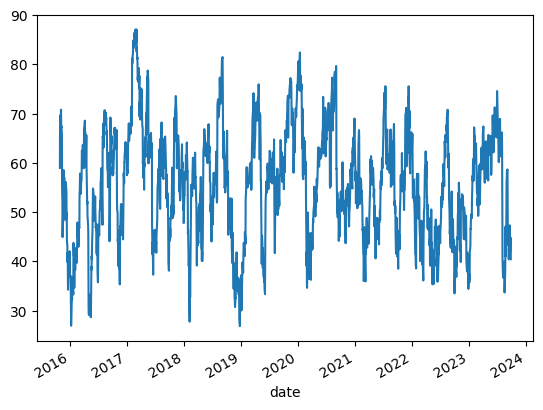

In [2]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

#RSI
""" 
Calculate the RSI (Relative Strength Index) for each stock (grouped by level 1 of the MultiIndex)
  'level=1' refers to the second level of the index, which is presumably the stock symbol (e.g., 'AAPL')
  'adj close' is the adjusted closing price for the stock
   The lambda function (lambda x) is applied to each group of 'adj close' prices
  'x' represents the series of adjusted close prices for each group (i.e., each stock)
   The RSI is calculated using a 20-day window and stored in a new column 'rsi'
"""
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Plot the RSI for the stock symbol 'AAPL'
"""
 The .xs('AAPL', level=1) method extracts data for 'AAPL' by filtering the MultiIndex on level 1
 The resulting RSI values are plotted over time
"""
df.xs('AAPL', level=1)['rsi'].plot()

# Bollinger Bands
"""
# Calculate the Bollinger Bands for the adjusted close prices of 'AAPL' over a 20-day period.
# Bollinger Bands consist of three lines: lower band (bb_low), middle band (bb_mid), and upper band (bb_high).
# These bands are often used in technical analysis to measure market volatility and identify potential buy or sell signals.
"""
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

"""
# Calculate the lower Bollinger Band (bb_low) for each stock (grouped by the stock symbol).
# The adjusted close prices are first log-transformed using numpy's log1p function (log(1 + x)) to stabilize variance.
# Then, the lower Bollinger Band (first column from bbands output) is computed and stored in the 'bb_low' column.
"""
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

"""
# Calculate the middle Bollinger Band (bb_mid) for each stock (grouped by the stock symbol).
# The log-transformed adjusted close prices are used to compute the middle Bollinger Band (second column from bbands output).
# The result is stored in the 'bb_mid' column, representing the 20-day moving average.
"""
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

"""
# Calculate the upper Bollinger Band (bb_high) for each stock (grouped by the stock symbol).
# The log-transformed adjusted close prices are used to compute the upper Bollinger Band (third column from bbands output).
# The result is stored in the 'bb_high' column, which indicates the upper boundary of the Bollinger Bands.
"""
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


#Calculate ATR Normalized for Machine Learning Model and Cluster the data
"""
# Function to Calculate the Normalized Average True Range (ATR) for a Given Stock's Data
#    ATR is a volatility indicator used in financial analysis, capturing the degree of price movement or market volatility.
#    In this function, the ATR is calculated using a 14-period window and is then normalized (standardized) 
#    to ensure that the output is suitable for use in machine learning models, where features typically need to be on a similar scale.
"""
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    """
    # Normalize the ATR by subtracting the mean and dividing by the standard deviation
    # This normalization ensures that the ATR has a mean of 0 and a standard deviation of 1,
    # which is crucial for maintaining consistent feature scales in machine learning models.
    """
    return atr.sub(atr.mean()).div(atr.std())
"""
# Apply the compute_atr function to each stock in the DataFrame, grouped by the stock symbol (level 1 of the MultiIndex)
# This ensures that the ATR is computed separately for each stock, maintaining the integrity of the individual stock's data.
# The result is stored in a new column 'atr', which will serve as a feature in subsequent machine learning tasks, 
# such as clustering, classification, or regression.
"""
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)


#Calculate MACD Normalized 
"""
# Function to Calculate the Normalized Moving Average Convergence Divergence (MACD) for Stock Prices
# MACD is a momentum indicator used in technical analysis, which shows the relationship between two moving averages of a stock's price.
# In this function, the MACD is computed using a 20-period window, then normalized (standardized) to prepare it as a feature 
# for machine learning models, ensuring consistency in feature scaling.
"""
def compute_macd(close):
    """
     # Calculate the MACD for the given stock's closing prices
     # MACD is derived from the difference between a short-term and a long-term exponential moving average (EMA)
     # Here, the first column of the MACD output (which is typically the MACD line) is extracted for further processing.
    """
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    """
    # Normalize the MACD by subtracting its mean and dividing by its standard deviation
    # Normalization standardizes the MACD, ensuring that it has a mean of 0 and a standard deviation of 1.
    # This is essential for machine learning algorithms, which often perform better when input features are normalized.
    """
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

"""
# Calculate the Dollar Volume for each stock and store it in a new column 'dollar_volume'
# Dollar Volume is a measure of liquidity and represents the total traded value of the stock in millions of dollars.
# It is computed by multiplying the adjusted closing price by the trading volume and then dividing by 1 million to convert it into millions.
# This metric is often used in financial analysis to understand the market impact and liquidity of a stock.
# The resulting 'dollar_volume' can be used as a feature in machine learning models, particularly in strategies that consider liquidity as a factor.
"""
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6
df

<h3>3.Aggregate to monthly level and filter top 150 most liquid stocks for each month.</h3>
<ul>
    <li>To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.</li>
</ul>

In [3]:
#Dollar Volume aggregation
"""
# Aggregating Dollar Volume to a Monthly Level and Filtering for Top 150 Most Liquid Stocks

# Identify columns to retain in the final dataset, excluding those that are directly related to price and volume data
# 'dollar_volume', 'volume', 'open', 'high', 'low', and 'close' are excluded as they are either aggregated or not needed for further analysis.
# The remaining columns in 'last_cols' typically contain relevant features (e.g., technical indicators or metadata) 
# that will be preserved during the aggregation process.
"""
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                         'high','low','close']]

"""
# Aggregate the 'dollar_volume' to a monthly level for each stock (identified by the 'ticker')
# Resample the data by month ('M') and calculate the mean dollar volume for each month.
# This aggregation helps to smooth out daily fluctuations and provides a more stable measure of liquidity over time.
"""
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

#Stack into multi index
"""
# Combine the monthly aggregated dollar volume with the last observed values of other relevant columns for each month
# The 'unstack' operation is used to move the 'ticker' level to columns, facilitating monthly resampling.
# The 'last' function is used on 'last_cols' to capture the most recent values at the end of each month, 
# ensuring that time-sensitive features are correctly aligned.
# The data is then stacked back into a multi-index format, and any rows with missing values are dropped to ensure data integrity.
"""
data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker') ], axis=1).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.740918   38.950893         -0.002098  73.421259   
           AAL        287.915799   39.429928         -0.000966  40.718936   
           AAPL      4019.331818   26.823095         -0.003391  55.537414   
           ABBV       334.491220   40.025845         -0.062372  49.376876   
           ABT        210.542077   38.091488         -0.011927  56.962554   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361755   78.356499         -0.000097  33.116230   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.304721  107.661491          0.000080  55.245480   
           GEHC       212.197210   66.105721          0.000185  40.922354   
           KVUE       664.360326   19.814009         -0.000410  35.706325   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689080 -1.033887  0.567158  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418773  
           AAPL    3.280565  3.323875  3.367185 -0.967900 -0.142789  
           ABBV    3.717771  3.766009  3.814247 -0.526809  0.145677  
           ABT     3.650901  3.672752  3.694603 -1.064842  0.335557  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366877  
           GEHC    4.155071  4.212607  4.270142 -0.893478 -1.116463  
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435621  

[46553 rows x 9 columns]

<ul>
    <li>Calculate 5-year rolling average of dollar volume for each stocks before filtering.</li>
</ul>

In [4]:
#Rolling Average Dollar Volume for each stock
"""
# Calculate the 5-Year Rolling Average of Dollar Volume for Each Stock
# The rolling window is set to 5 years (5*12 months) to smooth out short-term fluctuations and capture long-term trends in liquidity.
# 'min_periods=12' ensures that at least 12 months of data are required to compute the rolling average, 
# preventing biases from incomplete data early in the rolling window.
# The unstack operation temporarily removes the multi-index structure for easy calculation, 
# and the stack operation restores it after the rolling mean is calculated.
"""
data['dollar_volume']=(data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())


#Calculate Dollar Volume Rank Cross Sectionally for each month
"""
# Calculate the Cross-Sectional Rank of Dollar Volume for Each Month
# The ranking is done within each month ('date') across all stocks, in descending order (highest dollar volume gets the highest rank).
# This step identifies the most liquid stocks each month, which is crucial for filtering out the top performers for further analysis.
"""
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))


#Get top 150 most liquid stocks for each month
"""
# Filter to Retain the Top 150 Most Liquid Stocks for Each Month
# The top 150 stocks by dollar volume rank are selected for each month, 
# focusing the analysis on the most liquid and presumably most significant stocks.
# After filtering, the 'dollar_volume' and 'dollar_vol_rank' columns are dropped as they are no longer needed.
"""
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203550  3.604673   
           AAPL     26.182173         -0.002541  49.891129  3.293123   
           ABBV     39.878784         -0.049190  27.477786  3.744517   
           ABT      34.112480         -0.008074  38.008874  3.549492   
           ACN     103.117416         -0.005023  53.823731  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440187  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131597  
           AAPL    3.322002  3.350880 -1.038688 -0.195978  
           ABBV    3.798670  3.852823 -0.893132 -0.760594  
           ABT     3.599959  3.650426 -1.035224 -0.650888  
           ACN     4.644646  4.656283 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

<h3>4.Calculate Monthly Returns for different time horizons as features. </h3>
<ul>
    <li>To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.</li>
</ul>

In [5]:
# g = df.xs('AAPL', level=1)
# g
"""
# Function to Calculate Monthly Returns Over Different Time Horizons as Features
# This function calculates the returns for various time horizons (1, 2, 3, 6, 9, 12 months) 
# and creates new features representing these returns. It also handles outliers by clipping extreme values.
"""

def calculate_returns(df):
    #Clipping off the outlier stocks setting the threshhold 99.5 percentile
    # Clipping is used to limit the impact of extreme returns that might distort the model's learning process.
    # The lower and upper quantiles are used to set the range within which returns are considered "normal".
    outlier_cutoff = 0.005
    
    """
    # Define the time horizons (lags) for which returns will be calculated, expressed in months.
    # These lags represent different investment horizons, which are important features for understanding 
    # how a stock's past performance might influence future returns.
    """
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags: 
        """
         # Calculate the lagged returns:
        # 1. pct_change(lag): Computes the percentage change in the adjusted closing price over the given lag period.
        # 2. clip: Clips the returns to the defined outlier thresholds to remove extreme values.
        # 3. add(1): Adds 1 to the return to prepare for the annualization step (to avoid negative values during exponentiation).
        # 4. pow(1/lag): Annualizes the return over the given lag period (e.g., taking the 12th root for a 12-month return).
        # 5. sub(1): Subtracts 1 to revert back to the percentage return.
        """
        df[f'return_{lag}m'] = (df['adj close']
                             .pct_change(lag)
                             .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                               upper=x.quantile(1-outlier_cutoff)))
                             .add(1)
                             .pow(1/lag)
                             .sub(1))
    return df

"""
# Apply the calculate_returns function to each stock separately, grouped by stock symbol (level 1 of the MultiIndex).
# This ensures that returns are calculated independently for each stock's time series.
# The resulting DataFrame will include new features for the returns over different time horizons.
# Finally, rows with missing values (NaNs) are dropped to ensure a clean dataset for further analysis or modeling.
"""
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051774  3.849110   
           AAPL     39.667984         -0.001105  69.196628  3.593605   
           ABBV     66.876808         -0.036142  55.247908  4.187696   
           ABT      48.237453         -0.005677  53.844805  3.887384   
           ACN     128.834702         -0.004274  69.365112  4.798335   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440187  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.640476  3.687347 -0.906642 -0.039276   0.096808   
           ABBV    4.234051  4.280405  0.375557  0.473814   0.022728   
           ABT     3.910952  3.934519 -1.040044  0.276133   0.021276   
           ACN     4.838013  4.877691 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

<h3>5.Download Fama-French Factors and Calculate Rolling Factor Betas</h3>
<ul>
    <li>We will introduce the Fama - French data to estimate the exposure of assets to common risk factors using linear regression.</li>
    <li>The five Fama - French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exporsures as financial features in models. </li>
    <li>We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.</li>
</ul>

In [6]:
import pandas_datareader.data as web
"""
# Download the Fama-French 5-Factor data using pandas-datareader
# The 'F-F_Research_Data_5_Factors_2x3' dataset contains the five Fama-French factors:
# Market Risk (MKT-RF), Size (SMB), Value (HML), Profitability (RMW), and Investment (CMA).
# We use these factors to estimate the exposure of assets to common risk factors through linear regression.
"""
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
              'famafrench',
              start='2010')[0].drop('RF', axis=1)

"""
# Convert the index to a timestamp format, as the original data may have a period-based index
# This step ensures that the date information is appropriately formatted for further resampling and analysis.
"""
factor_data.index = factor_data.index.to_timestamp()

"""
# Resample the factor data to a monthly frequency and take the last observation of each month
# Fama-French data is typically provided at a higher frequency (e.g., daily), but for our analysis, we aggregate it to monthly data.
# Dividing by 100 converts the factor returns from percentages to decimal form (e.g., 1% becomes 0.01).
"""
factor_data = factor_data.resample('M').last().div(100)

"""
# Set the index name to 'date' for clarity and consistency with other datasets
# This step makes the index name explicit, which is particularly useful when merging or joining with other data sources.
"""
factor_data.index.name = 'date'

"""
# Join the factor data with the monthly asset returns from our existing dataset
# This combines the Fama-French factor data with our calculated monthly returns ('return_1m') for each stock.
# The result is a dataset that contains both the asset returns and the factor returns, allowing us to estimate factor exposures.
# Sorting by index ensures that the data is in chronological order, which is essential for time-series analysis.
"""
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10340 rows x 6 columns]

In [7]:
factor_data.xs('AAPL', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2017-10-31  0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096808
2017-11-30  0.0312 -0.0033 -0.0003  0.0318 -0.0006   0.020278
2017-12-31  0.0106 -0.0106  0.0006  0.0075  0.0170  -0.015246
2018-01-31  0.0557 -0.0317 -0.0129 -0.0075 -0.0091  -0.010636
2018-02-28 -0.0365  0.0032 -0.0104  0.0048 -0.0228   0.068185

In [8]:
factor_data.xs('MSFT', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2017-10-31  0.0225 -0.0194  0.0020  0.0090 -0.0327   0.116660
2017-11-30  0.0312 -0.0033 -0.0003  0.0318 -0.0006   0.016984
2017-12-31  0.0106 -0.0106  0.0006  0.0075  0.0170   0.016277
2018-01-31  0.0557 -0.0317 -0.0129 -0.0075 -0.0091   0.110708
2018-02-28 -0.0365  0.0032 -0.0104  0.0048 -0.0228  -0.008415

<ul>
    <li>Filter out stocks with less than 10 months of data</li>
</ul>

In [9]:
#Why because we are going to use Rolling Window of regression of 2 years
"""
# Filter out stocks with less than 10 months of data
# Why? Because we plan to use a Rolling Window of regression over a 2-year period.
# A rolling regression requires a sufficient number of data points to produce meaningful results.
# By ensuring that each stock has at least 10 months of data, we ensure the reliability of our regression analysis.
"""
observations = factor_data.groupby(level=1).size()

"""
# Identify stocks that have at least 10 months of data
# This step filters out stocks with insufficient historical data, as they would not provide a reliable basis 
# for estimating factor betas over the intended rolling window period.
"""
valid_stocks = observations[observations >= 10]

"""
# Keep only the data for stocks that meet the minimum data requirement
# We filter the factor_data DataFrame to retain only those stocks that are present in the valid_stocks list.
# This ensures that subsequent analysis, such as the rolling regression, is performed on a dataset with adequate historical data.
"""
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0090 -0.0327  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0090 -0.0327   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0090 -0.0327   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.009617
           VZ     -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.056890
           WFC    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.015500
           WMT    -0.0524 -0.0179  0.0151  0.0191 -0.0077  -0.000676
           XOM    -0.0524 -0.0179  0.0151  0.0191 -0.0077   0.046947

[10307 rows x 6 columns]

<ul>
    <li>Calculate Rolling Factor Betas</li>
</ul>

In [10]:
"""
# Calculate Rolling Factor Betas for Each Stock Using a Rolling Window Regression
# Apply rolling regression for each stock (grouped by the stock symbol at level 1 of the index)
# RollingOLS is used to estimate time-varying (rolling) factor betas, capturing how a stock's exposure to 
# various risk factors evolves over time.
"""

betas= (factor_data.groupby(level=1,
                    group_keys=False)
        # Apply a lambda function to each stock's data, which performs the rolling regression
        .apply(lambda x: RollingOLS(endog=x['return_1m'],# The dependent variable is the 1-month return of the stock
                           exog=sm.add_constant(x.drop('return_1m', axis=1)), # The independent variables are the Fama-French factors
                           # Add a constant to the independent variables to estimate the intercept in the regression model.
                           window=min(24, x.shape[0]),  # Set the rolling window to 24 months (2 years) or less if the stock has fewer data points.
                           # The window parameter determines how many past observations are used in each regression.
                           # min(24, x.shape[0]) ensures that the window does not exceed the available data points for stocks with limited history.
                           min_nobs=len(x.columns)+1) # Minimum number of observations required to perform the regression
                           # This ensures that there are enough data points to estimate the coefficients reliably.
         .fit(params_only=True) # Fit the model but only return the parameter estimates (betas)
         .params # Extract the regression coefficients (betas) for each factor
         .drop('const', axis=1))) # Drop the constant (intercept) term from the results, as we are interested in factor betas only
"""
# The resulting 'betas' DataFrame contains the rolling factor betas for each stock over time.
# These betas represent the sensitivity of each stock to the Fama-French factors within a rolling 2-year window.
# The rolling nature of the betas allows us to observe how a stock's exposure to different risk factors changes over time.
"""
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456089 -0.460026 -0.281339 -0.074279  0.761453
           VZ      0.331581 -0.173421  0.290306  0.315698  0.071477
           WFC     1.119315  0.309058  2.035944 -0.441943 -1.504620
           WMT     0.700667 -0.312948 -0.416687 -0.138962  0.516750
           XOM     0.978566 -1.095949  1.773610 -0.624864 -0.412272

[10307 rows x 5 columns]

In [11]:
"""
groupby('ticker'):
This operation groups the betas DataFrame by the ticker column (which represents the stock symbol). 
Grouping is done so that operations can be applied independently within each group (i.e., within each stock's data).
shift():
The shift() function shifts the data within each group by one period 
(by default, it shifts by one row downward). This means that each value is moved to 
the next row within the group, and the first row for each group becomes NaN 
(because there's no previous value to shift into it).
"""
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.504056 -0.425420 -0.450521  0.061170  0.907316
           VZ      0.300525 -0.220341  0.367583  0.325815 -0.037172
           WFC     1.137047  0.325592  1.978325 -0.406799 -1.448529
           WMT     0.740335 -0.259861 -0.524399 -0.124577  0.651561
           XOM     1.001239 -1.055137  1.725820 -0.658414 -0.329147

[10307 rows x 5 columns]

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10126 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10126 non-null  float64
 1   rsi               10126 non-null  float64
 2   bb_low            10126 non-null  float64
 3   bb_mid            10126 non-null  float64
 4   bb_high           10126 non-null  float64
 5   atr               10126 non-null  float64
 6   macd              10126 non-null  float64
 7   return_1m         10126 non-null  float64
 8   return_2m         10126 non-null  float64
 9   return_3m         10126 non-null  float64
 10  return_6m         10126 non-null  float64
 11  return_9m         10126 non-null  float64
 12  return_12m        10126 non-null  float64
 13  Mkt-RF            10126 non-null  float64
 14  SMB               10126 non-null  float64
 15  HML       

<p>Use machine learning model to choose which stocks to include in the portfolio.</p>
<p>Long portfolio. We can use Machine Learning Model to determine the magnitude of the position in each stocks. </p>
<h2>At this point we have to decide on what ML model and approach to use for predictions etc.</h2>

<h3>6. For each month fit a K-Mans Clustering Algorithm to group similar assets based on their features.</h3>
<h2>K-Means Clustering</h2>
<ul>
    <li>Split the stocks into 4 different clusters based on its features. 4 because it is the optimum number of clusters.</li>
    <li>You may want to initialize predefined centroids for each cluster based on your research.</li>
    <li>For visualization purpose of this tutorial we will initially rely on the "k-means++" initialization.</li>
    <li>Then we will pre-define our centroids for each cluster.</li>
</ul>

In [13]:
#Import the KMeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans

"""
# Drop any existing 'cluster' column from the data
# This ensures that any previous clustering labels are removed before applying the new clustering process.
# It is important to start with a clean dataset to avoid potential conflicts or inaccuracies in the clustering results.
"""
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Function to Apply KMeans Clustering to the Data for Each Date
def get_clusters(df):
    """
    # Apply KMeans clustering to the data, creating 4 distinct clusters
    # The number of clusters (n_clusters=4) is predetermined based on domain knowledge or prior experimentation.
    # random_state=0 ensures reproducibility of the clustering results by setting the random seed.
    # init=initial_centroids allows us to specify the initial centroids for KMeans, which can be important for achieving 
    # stable and meaningful clustering results, especially in an institutional setting where consistency is critical.
    """
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='k-means++').fit(df).labels_
    return df
"""
# Drop rows with missing values (NaN) to ensure clean input data for clustering
# Missing data can lead to errors or biased clustering results, so it's crucial to handle NaNs appropriately.
# Group the data by 'date' and apply the get_clusters function to each group independently
# This ensures that the clustering is performed separately for each time period, capturing the evolving patterns in the data.
# In an institutional context, it's often necessary to track how asset classes or portfolios evolve over time,
# making it essential to apply clustering within each time slice (in this case, monthly or daily).
"""
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051774  3.849110  3.921750  3.994389   
           AAPL           -0.001105  69.196628  3.593605  3.640476  3.687347   
           ABBV           -0.036142  55.247908  4.187696  4.234051  4.280405   
           ABT            -0.005677  53.844805  3.887384  3.910952  3.934519   
           ACN            -0.004274  69.365112  4.798335  4.838013  4.877691   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -0.000041  54.722528  3.984976  4.002446  4.019915   
           XOM            -0.000065  59.440187  4.687091  4.727187  4.767283   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   
           CRWD            0.000144  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039276   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473814   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276133   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399458  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.263867  1.322360   
           AAPL     0.028875   0.038941    0.035228  1.273283 -0.270024   
           ABBV     0.056495   0.047273    0.044026  0.494007  0.372027   
           ABT      0.038672   0.031320    0.029294  0.829747 -0.202849   
           ACN      0.028692   0.027398    0.018728  1.199274 -0.166729   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740335 -0.259861   
           XOM      0.012838   0.008747    0.027037  1.001239 -1.055137   
           MRNA    -0.071952  -0.064976   -0.015431  1.155517  0.767772   
           UBER     0.057244   0.066838    0.043691  1.080479  1.180797   
           CRWD     0.026391   0.047942   -0.002216  0.595945 -0.916784   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.589851  0.475525  0.574170        3  
           AAPL   -0.592822  0.656516  0.458467        0  
           ABBV   -0.045655  0.257912  0.183431        2  
           ABT    -0.528482  0.244478  0.972083        2  
           ACN    -0.329662  0.266734  0.173059        0  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.524399 -0.124577  0.651561        3  
           XOM     1.725820 -0.658414 -0.329147        3  
           MRNA   -1.156852  0.597846  0.995470        0  
           UBER   -0.303488 -1.488702 -0.381346        1  
           CRWD   -0.739516 -2.459211 -0.722896        3  

[10126 rows x 19 columns]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10126 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10126 non-null  float64
 1   rsi               10126 non-null  float64
 2   bb_low            10126 non-null  float64
 3   bb_mid            10126 non-null  float64
 4   bb_high           10126 non-null  float64
 5   atr               10126 non-null  float64
 6   macd              10126 non-null  float64
 7   return_1m         10126 non-null  float64
 8   return_2m         10126 non-null  float64
 9   return_3m         10126 non-null  float64
 10  return_6m         10126 non-null  float64
 11  return_9m         10126 non-null  float64
 12  return_12m        10126 non-null  float64
 13  Mkt-RF            10126 non-null  float64
 14  SMB               10126 non-null  float64
 15  HML       

In [15]:
# Atr = 5 RSI = 1
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

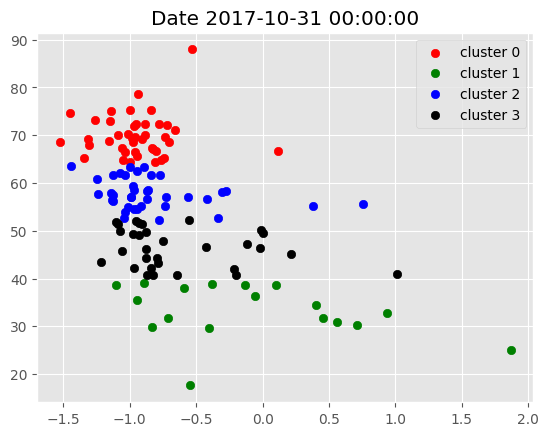

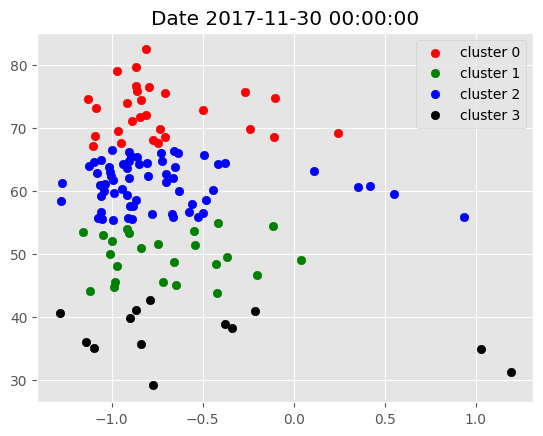

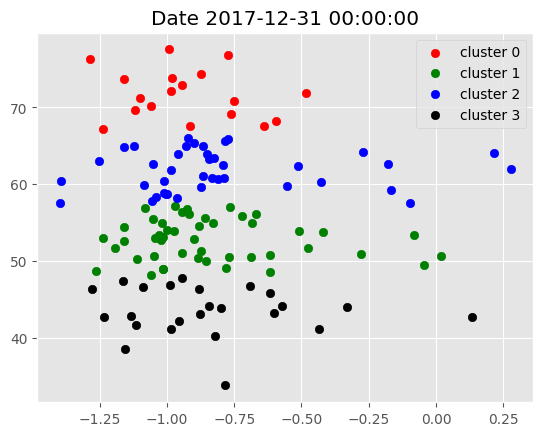

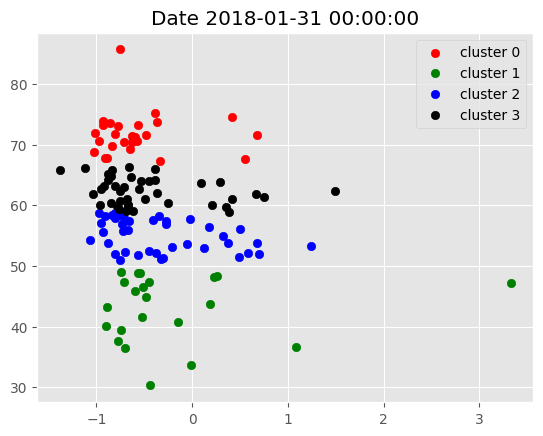

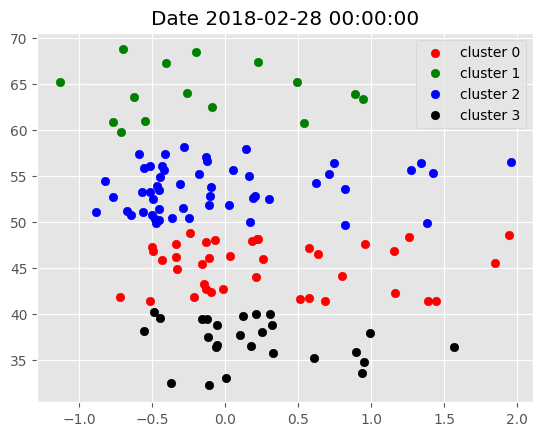

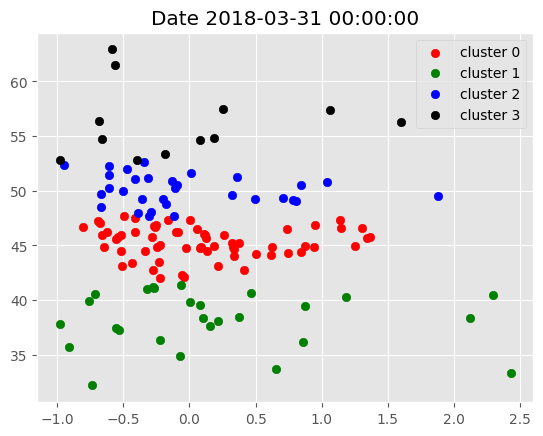

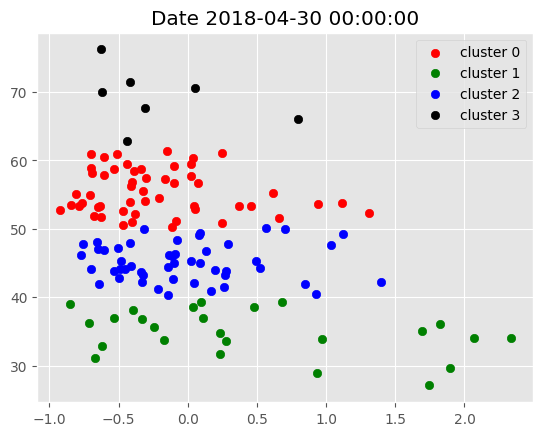

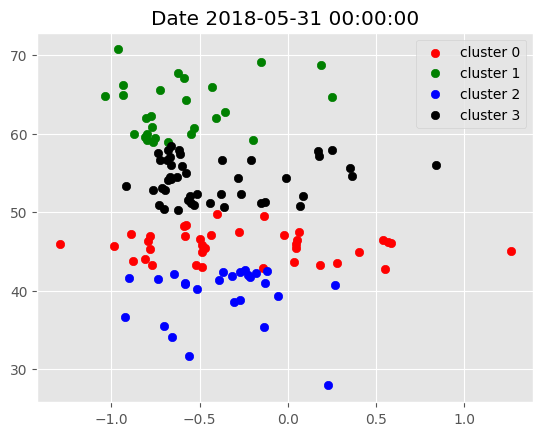

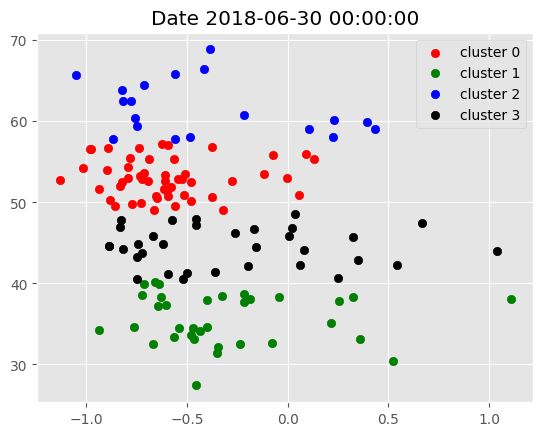

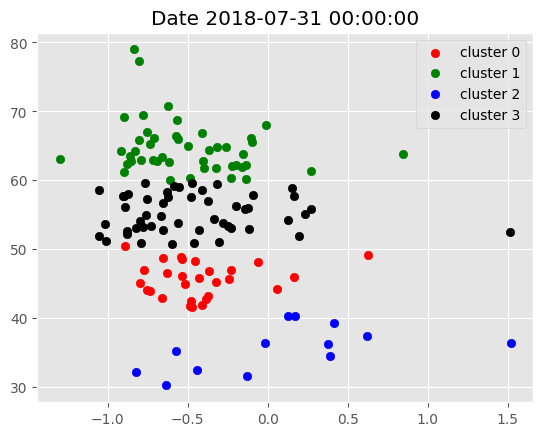

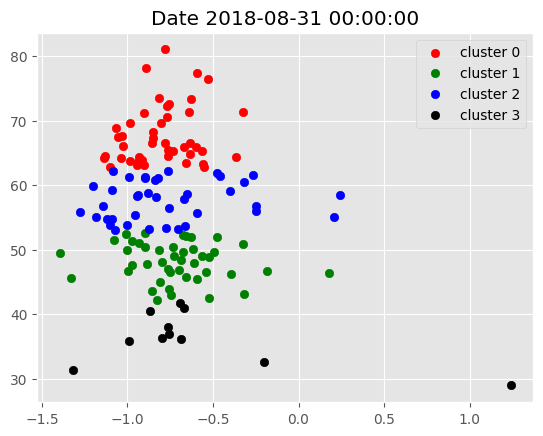

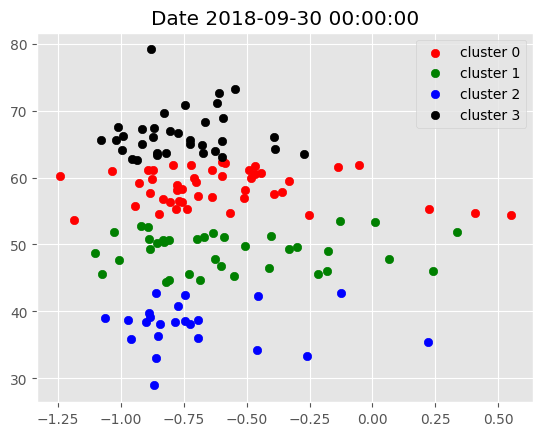

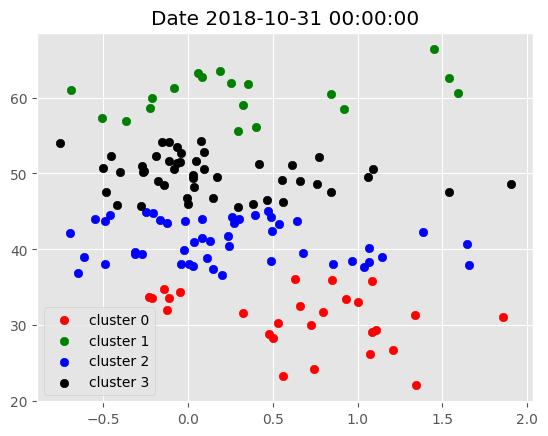

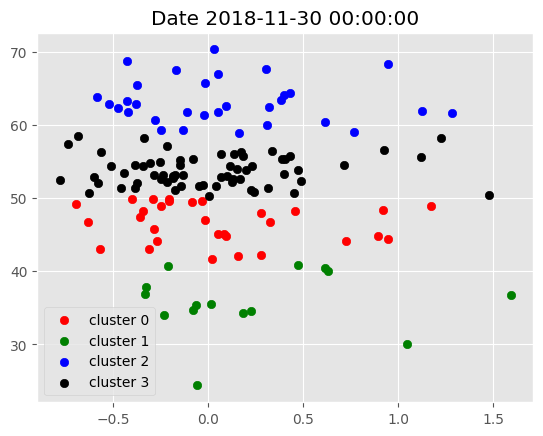

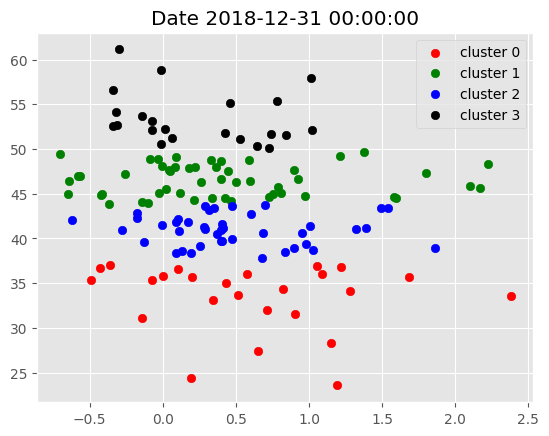

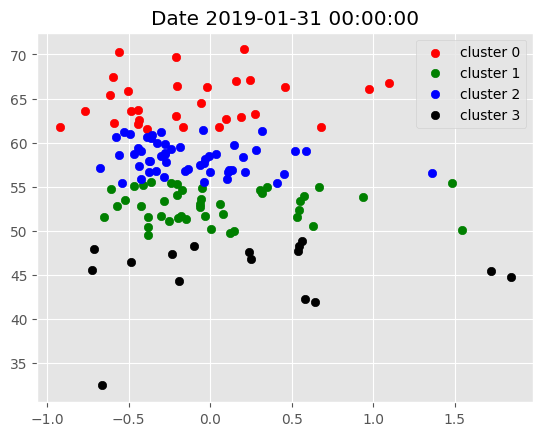

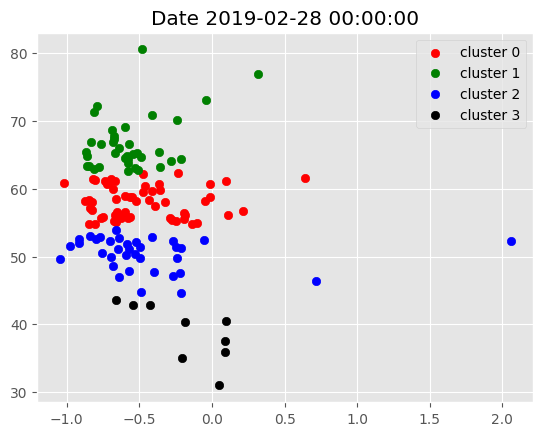

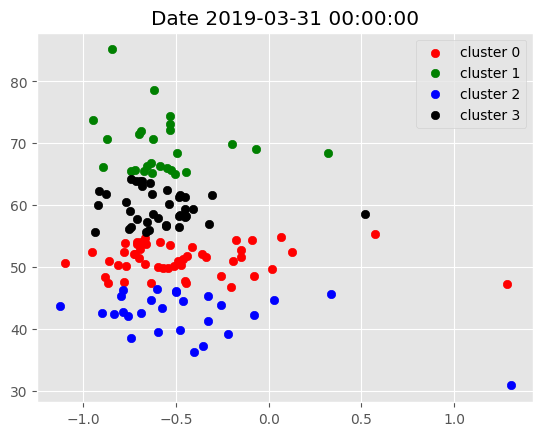

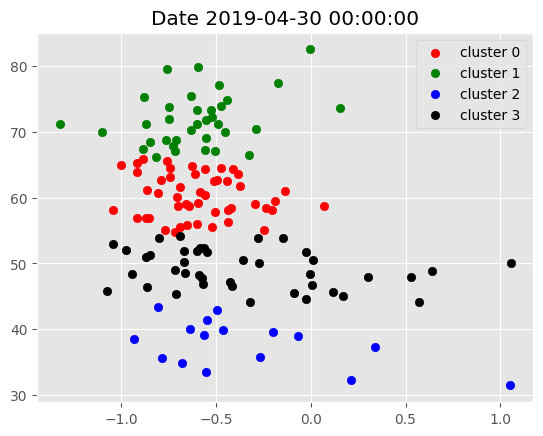

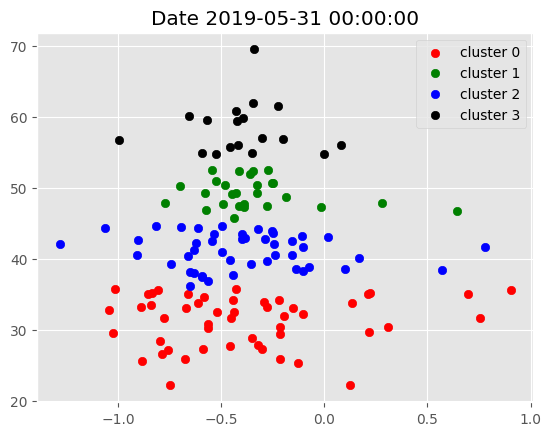

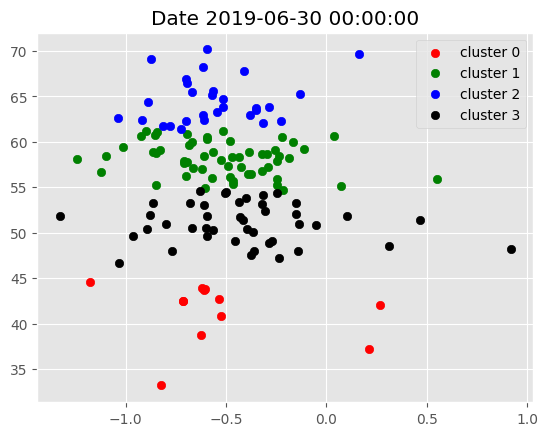

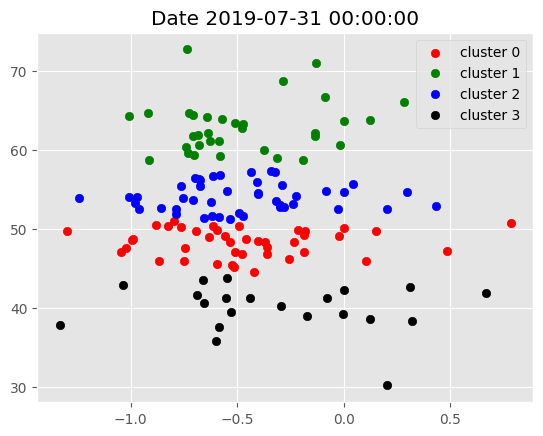

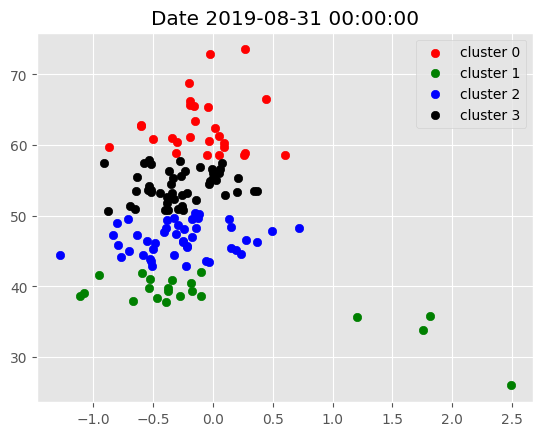

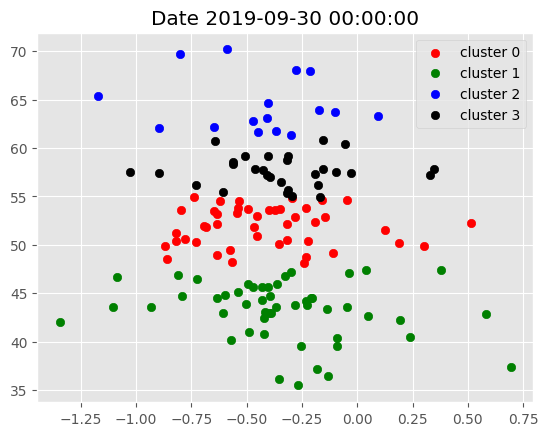

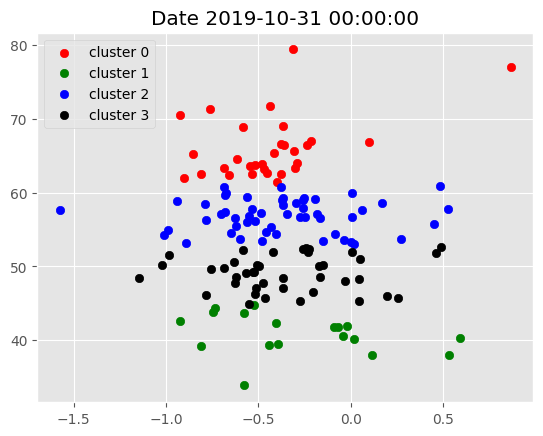

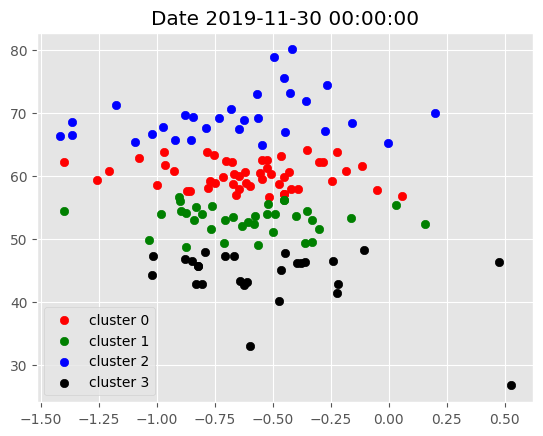

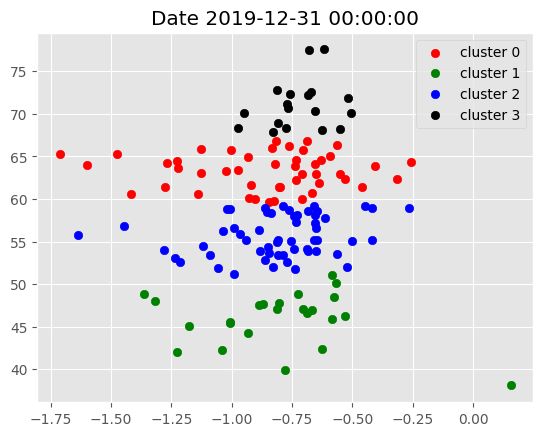

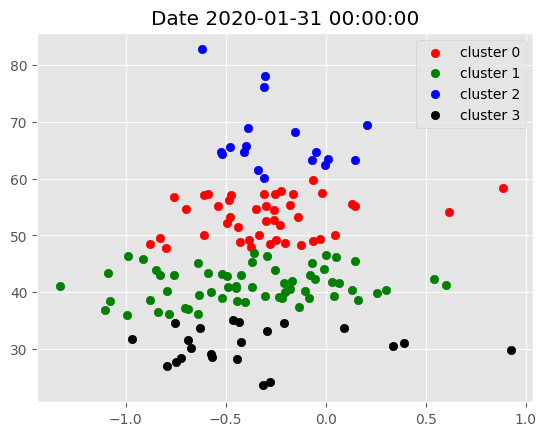

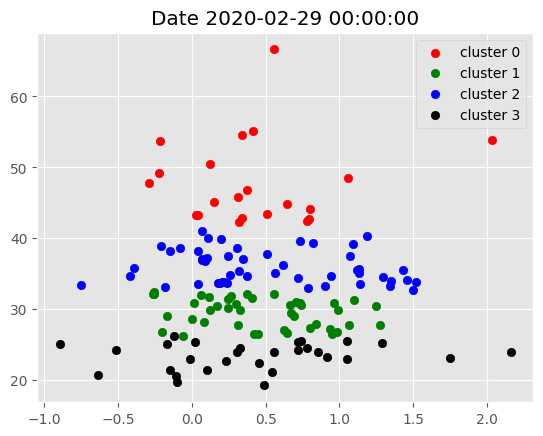

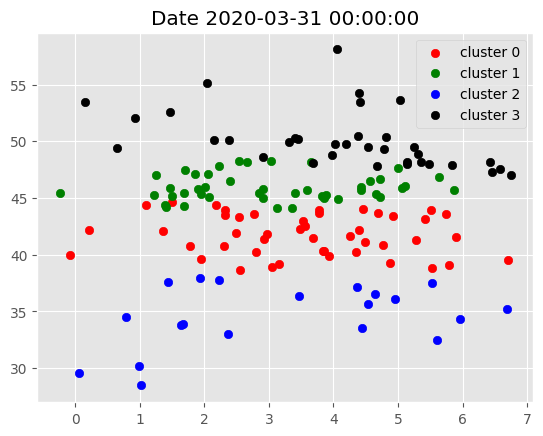

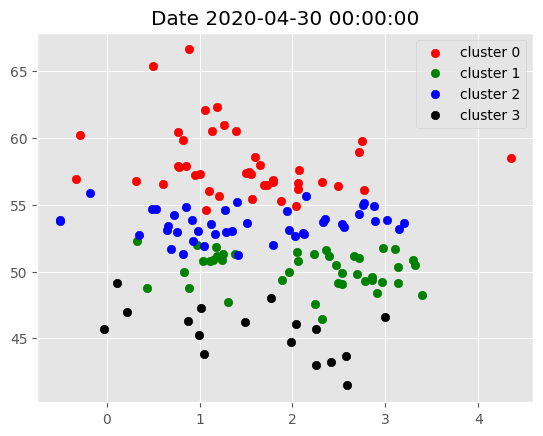

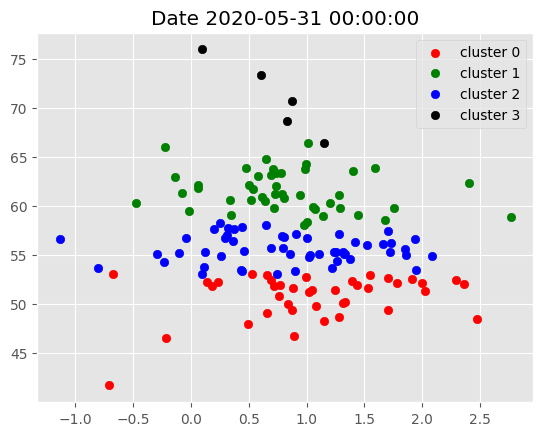

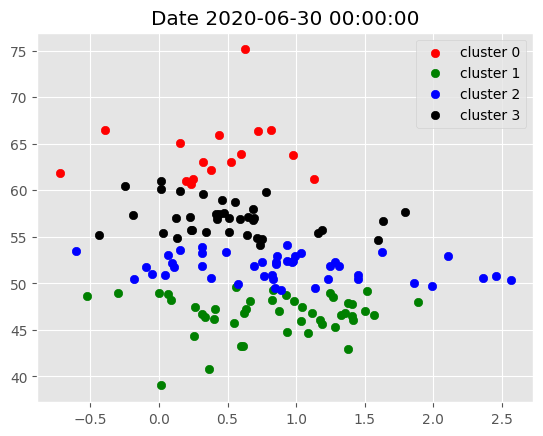

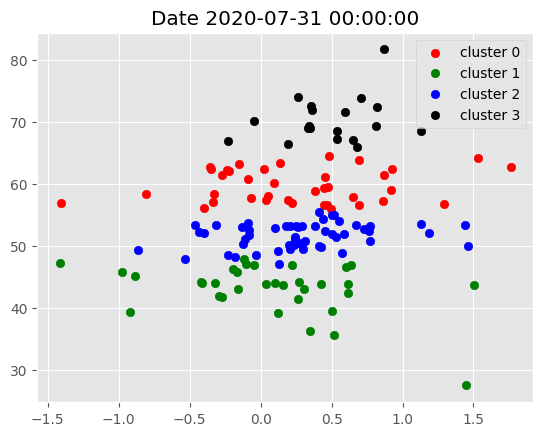

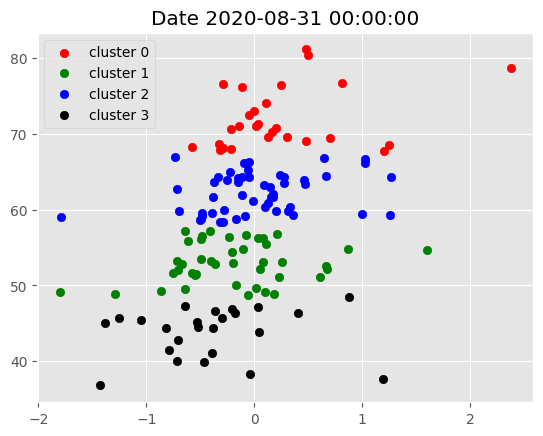

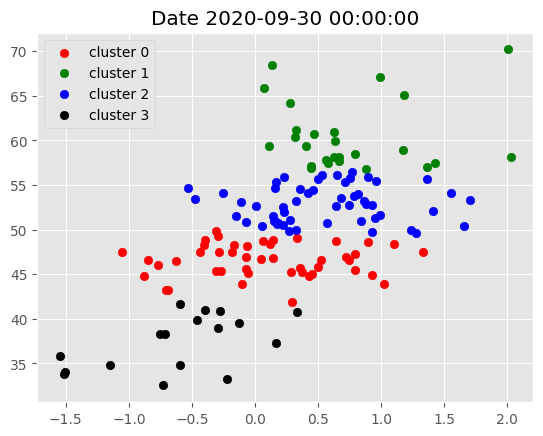

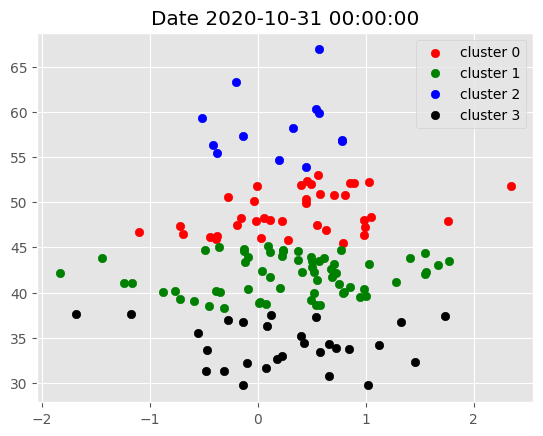

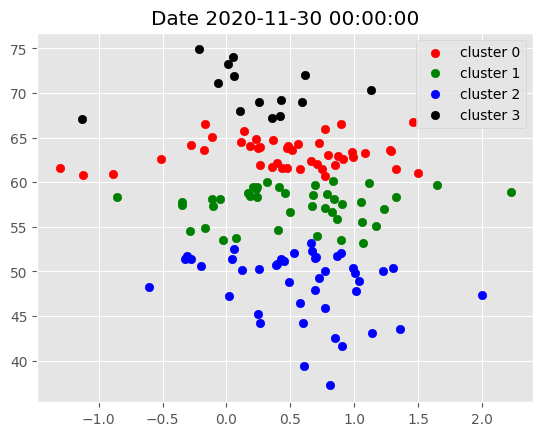

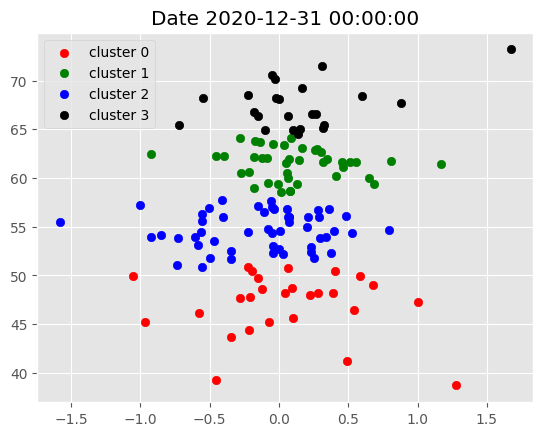

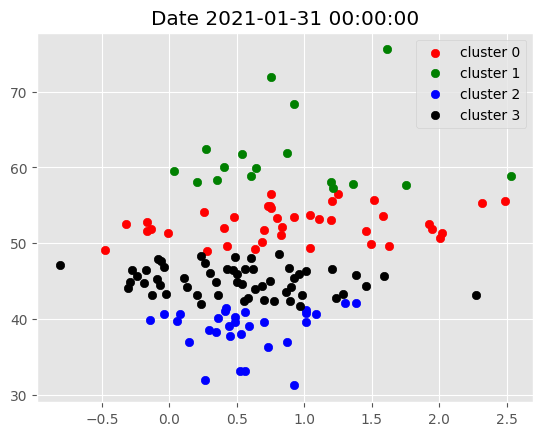

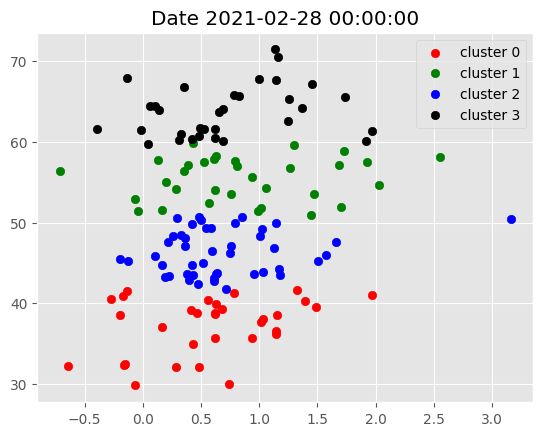

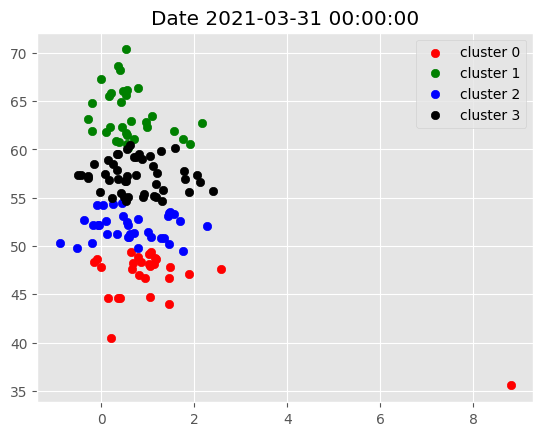

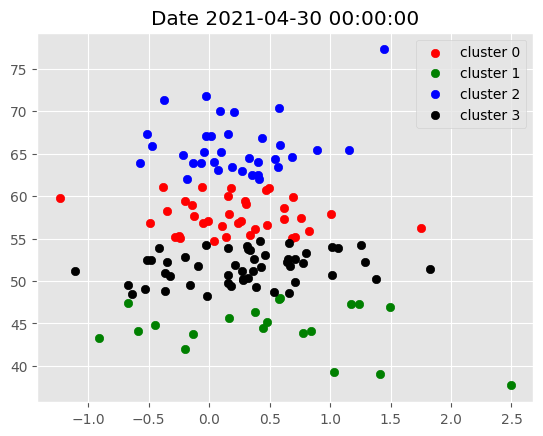

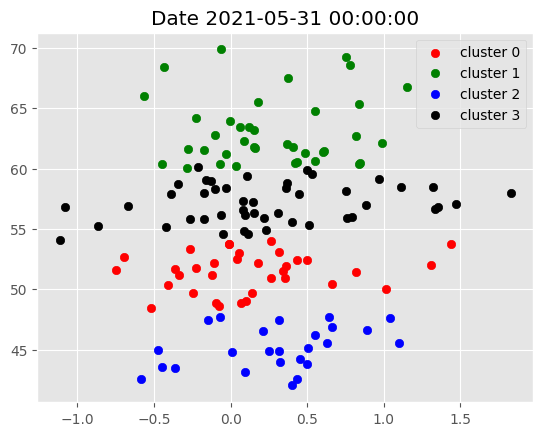

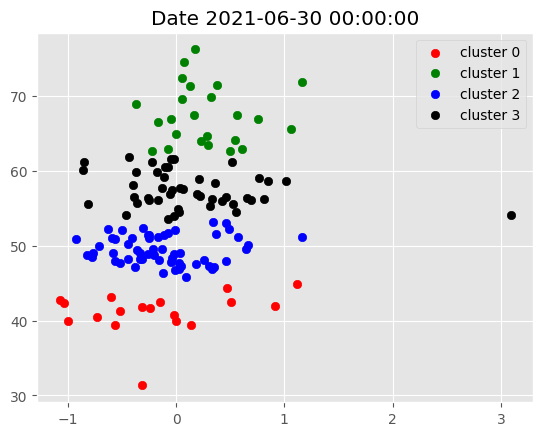

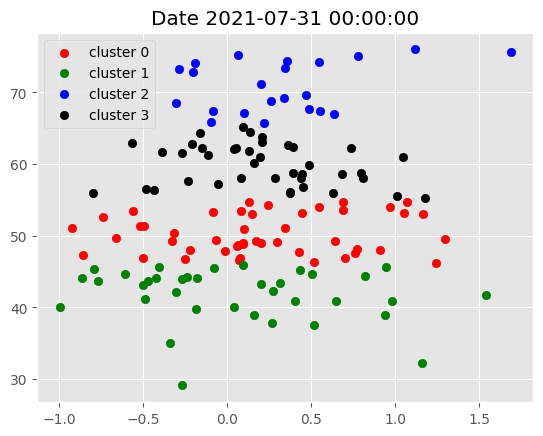

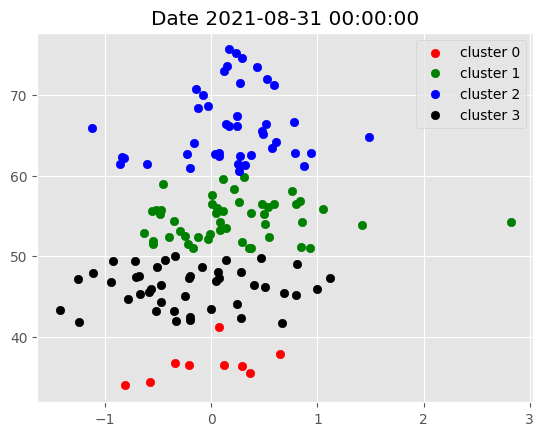

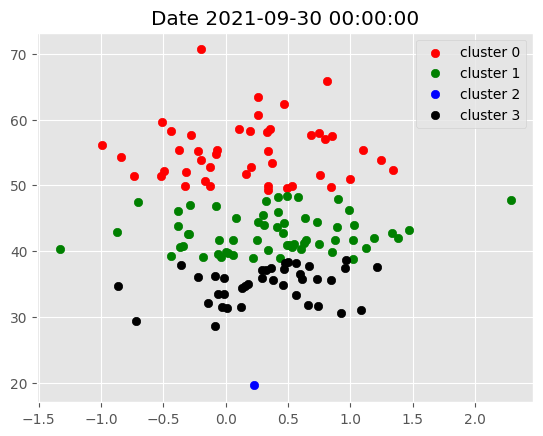

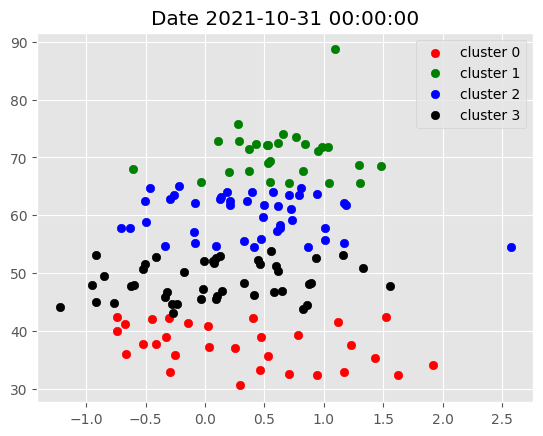

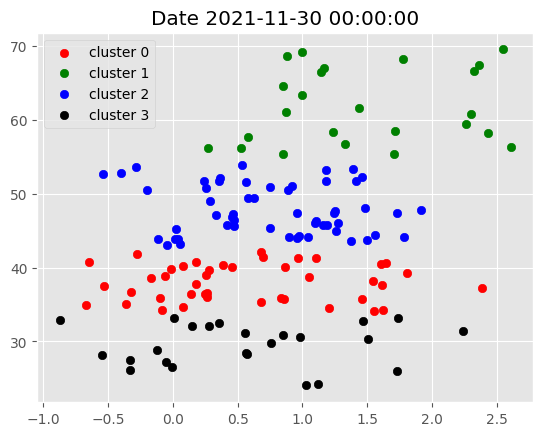

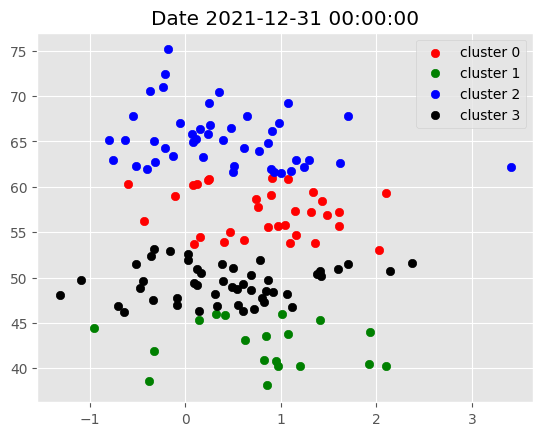

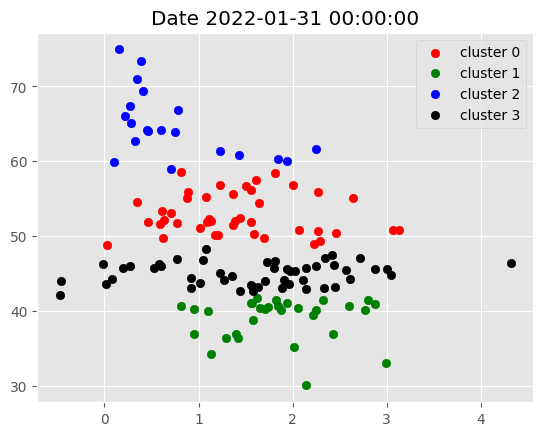

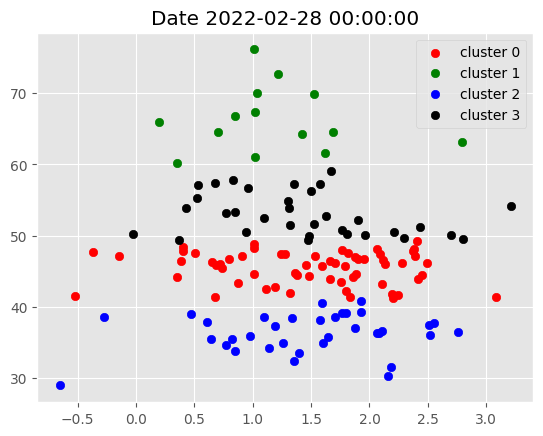

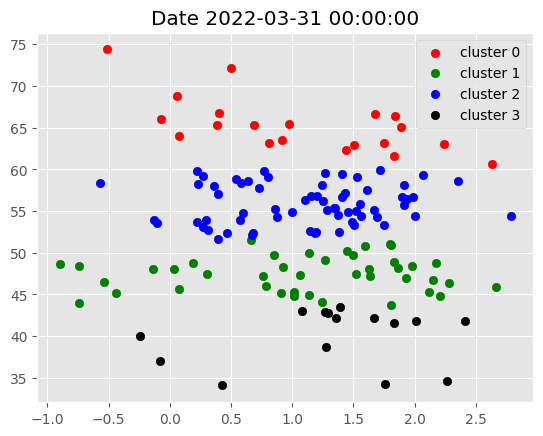

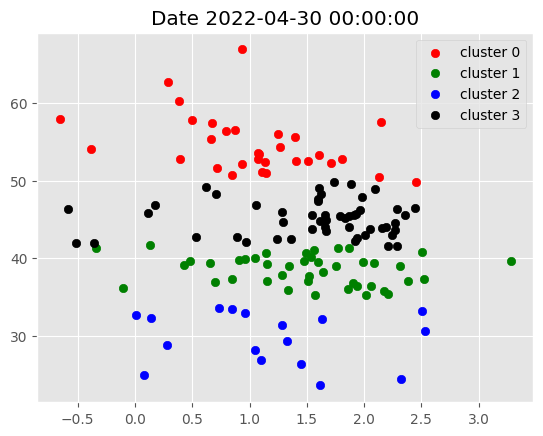

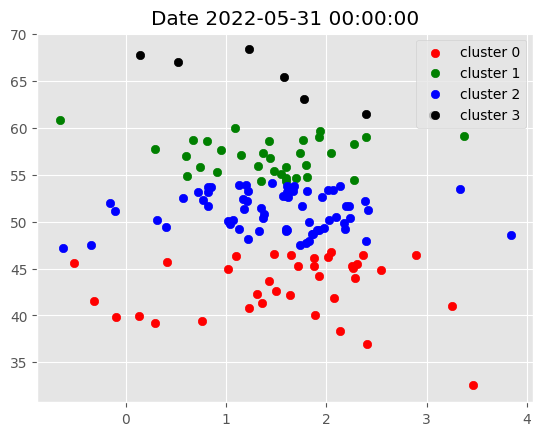

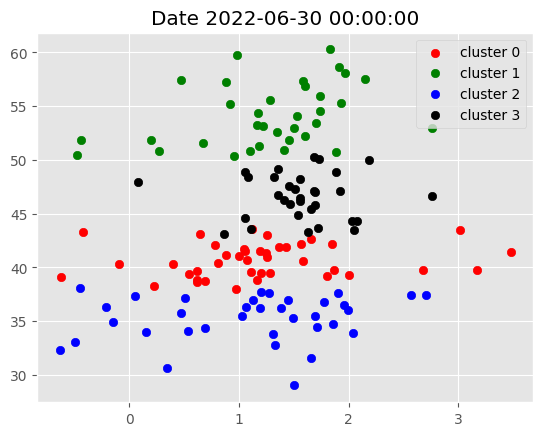

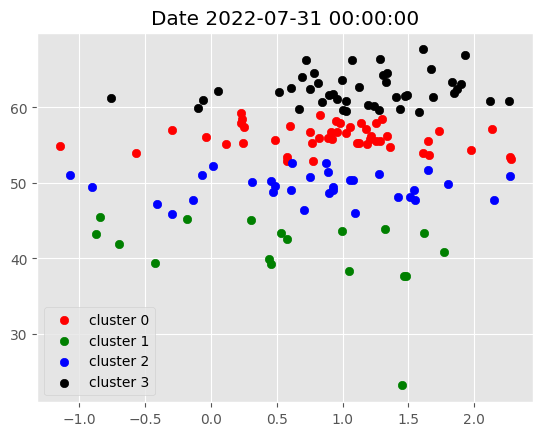

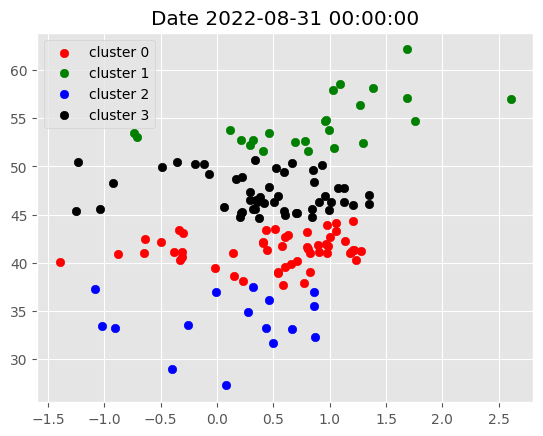

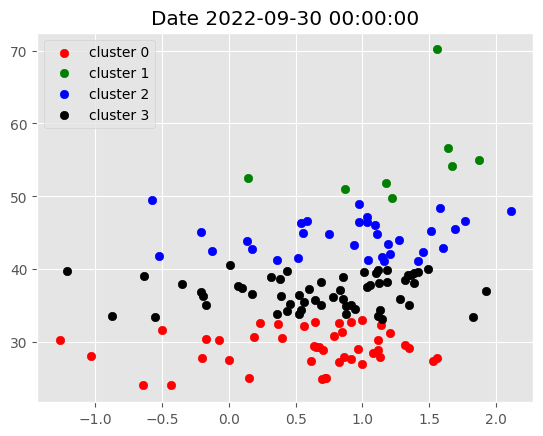

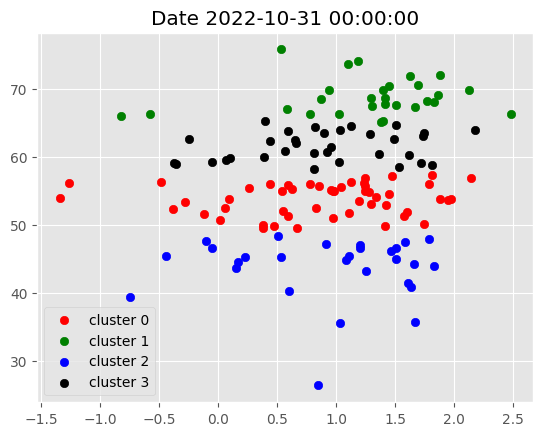

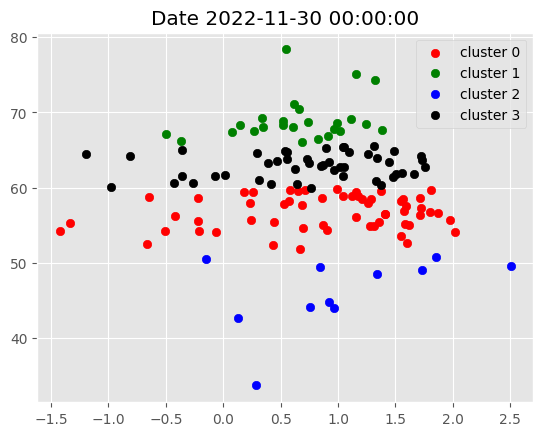

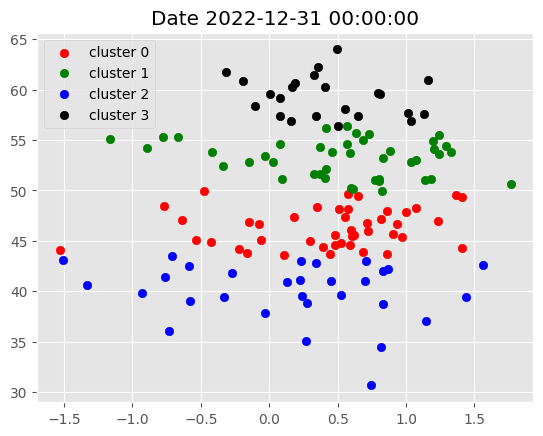

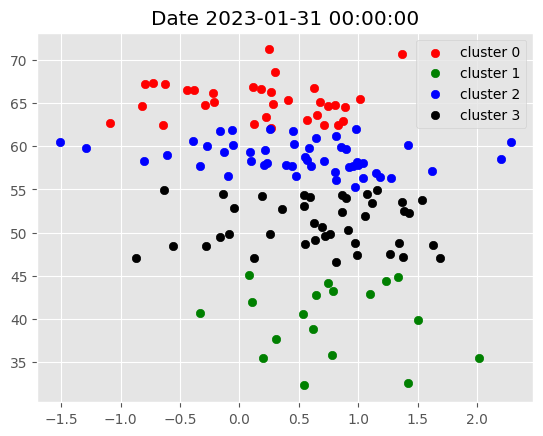

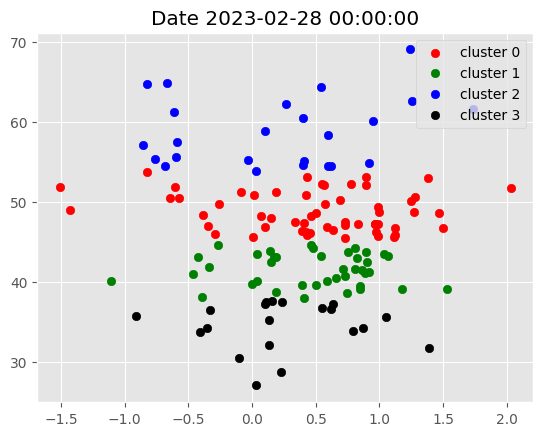

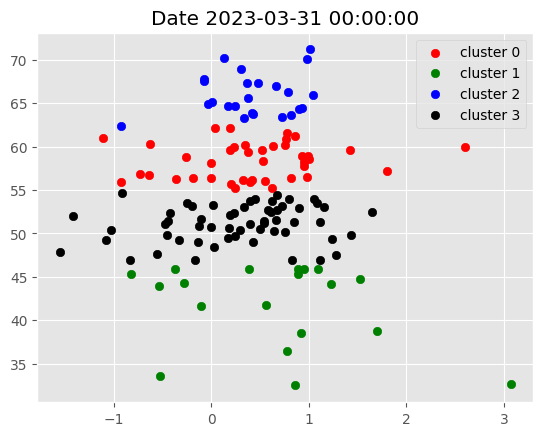

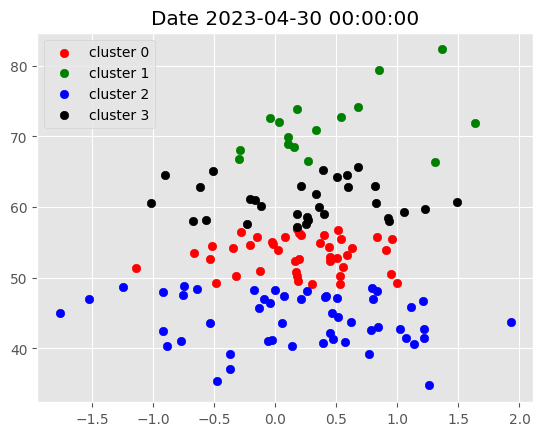

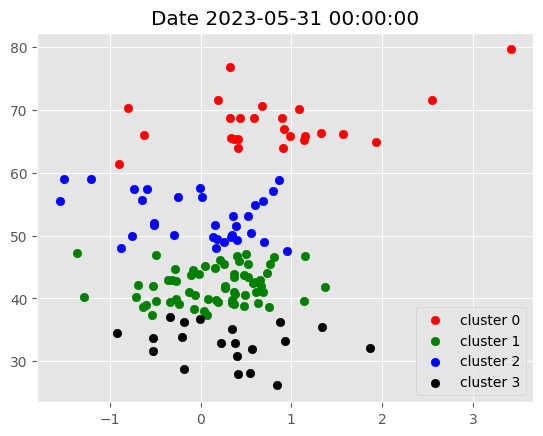

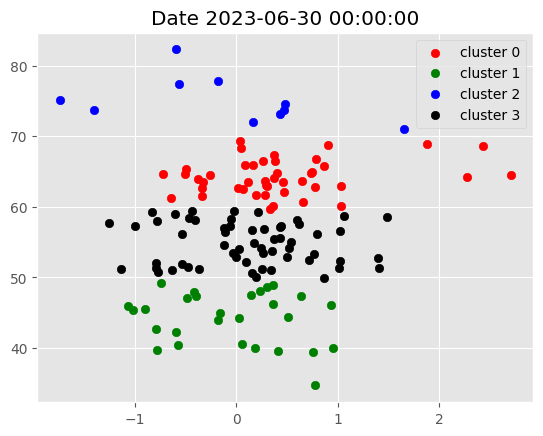

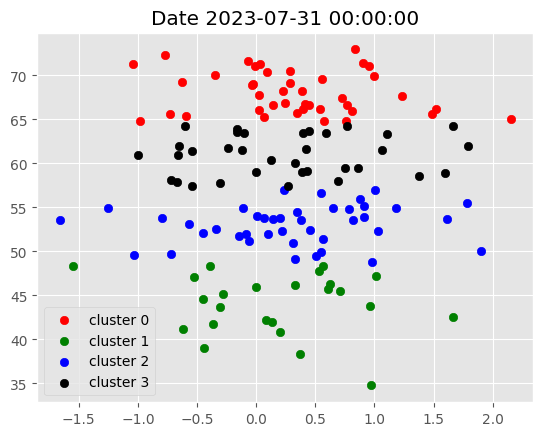

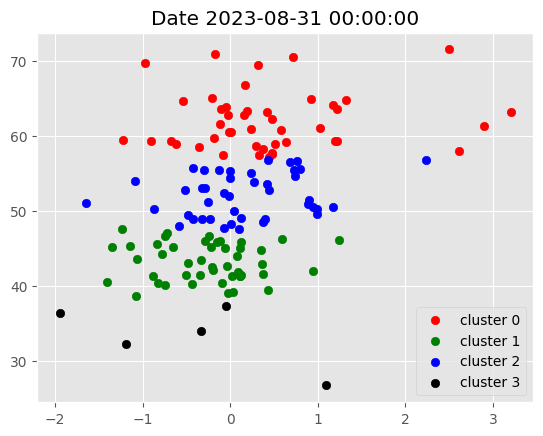

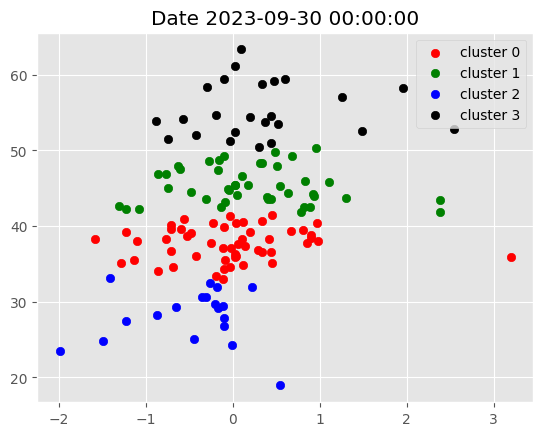

In [16]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

    #the coloring of the cluster cetroids is random
    #Strategy Follow Stocks Momentum: Stocks around 70 rsi are in upward momentum. Invest in stocks of high 60-75 upward rsi momentum
        

<h3>Apply Pre-Defined Centroids to take out the randomness.</h3>

In [17]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

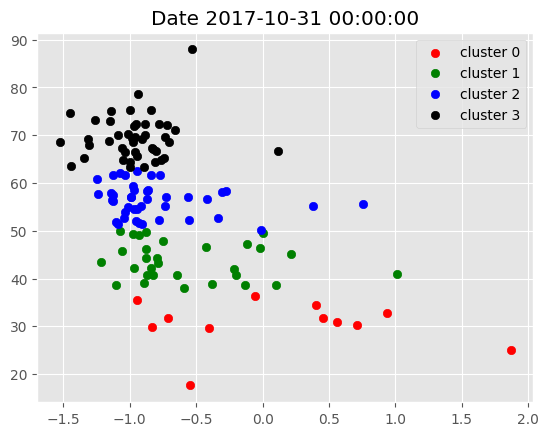

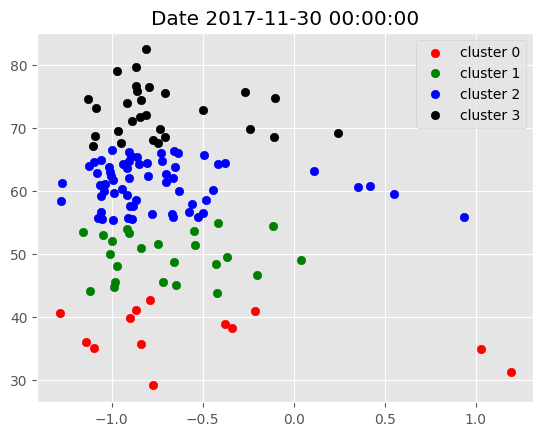

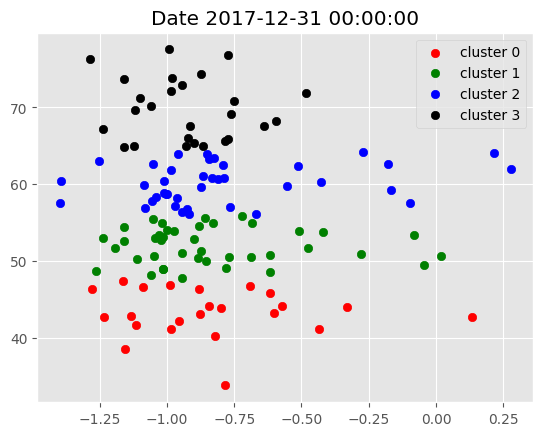

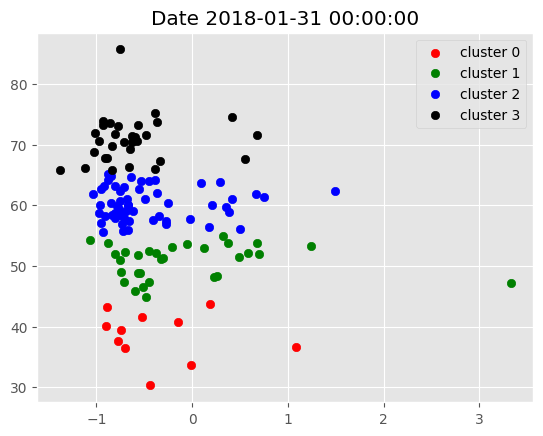

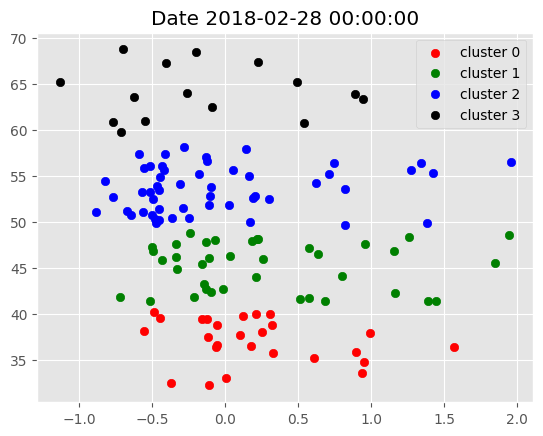

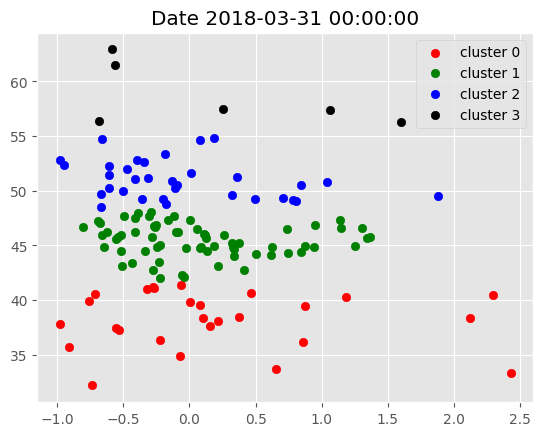

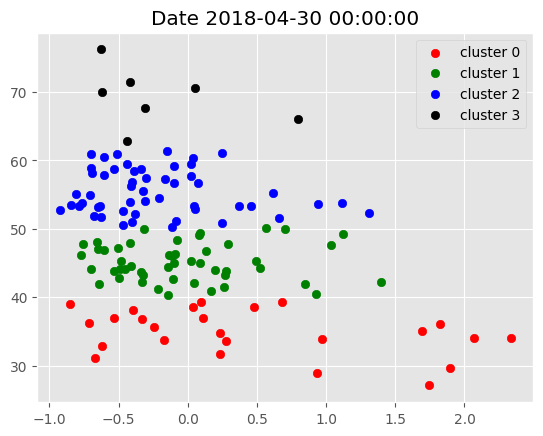

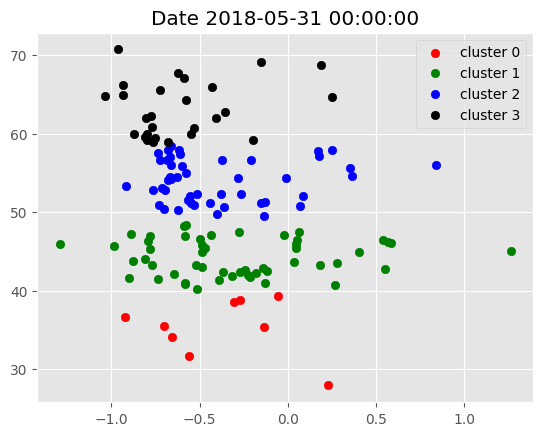

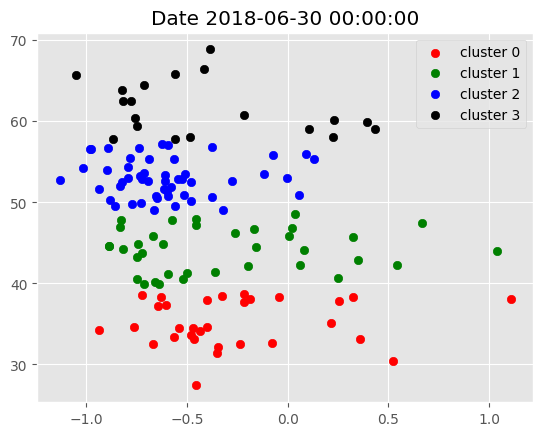

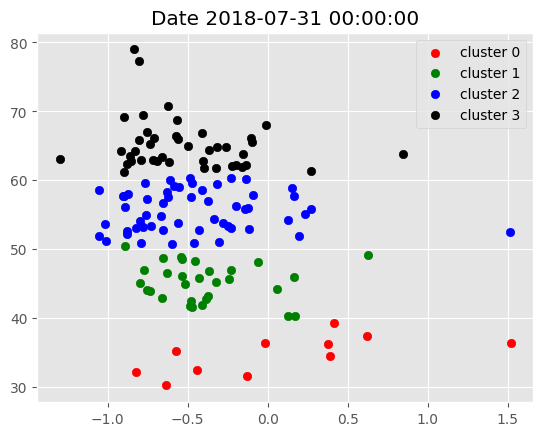

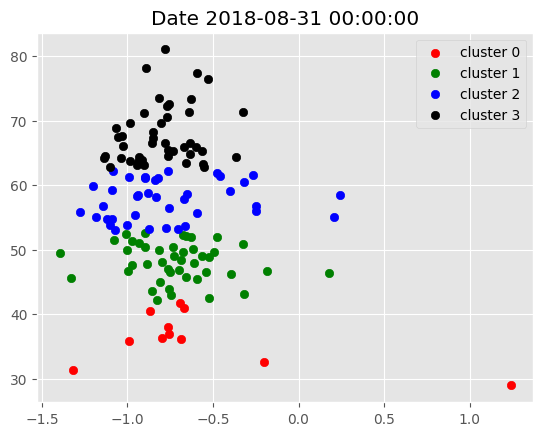

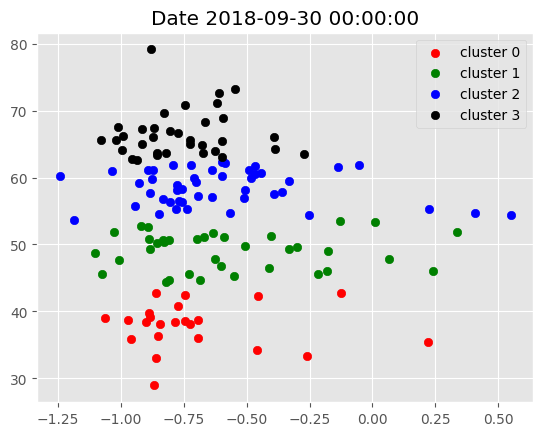

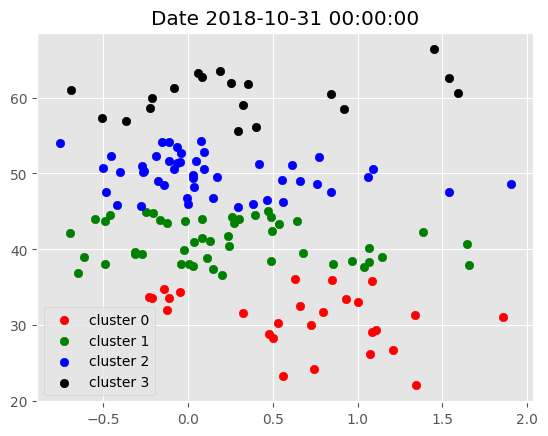

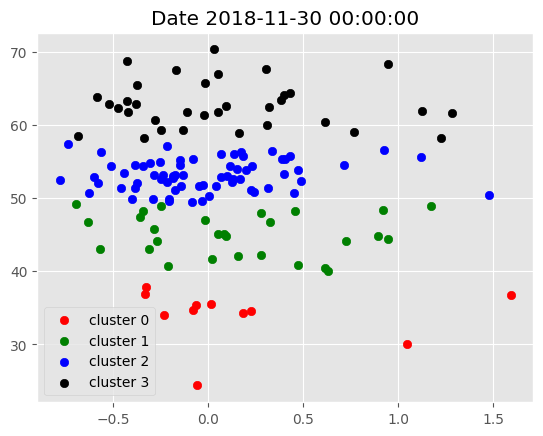

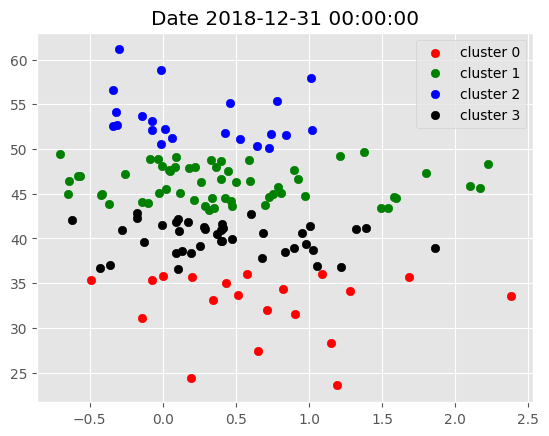

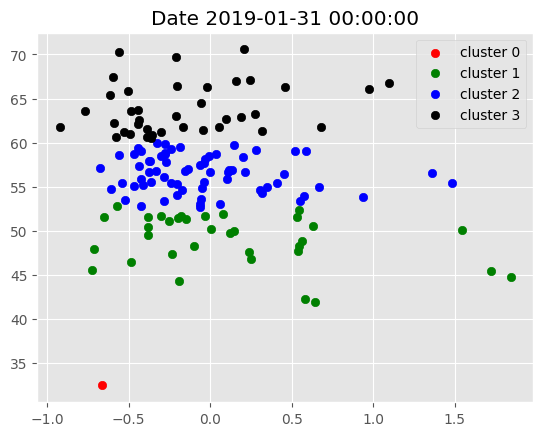

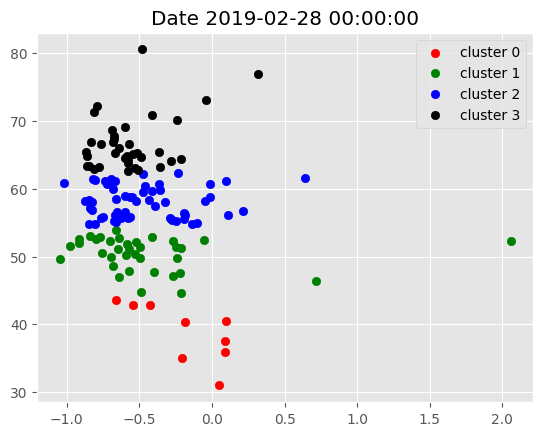

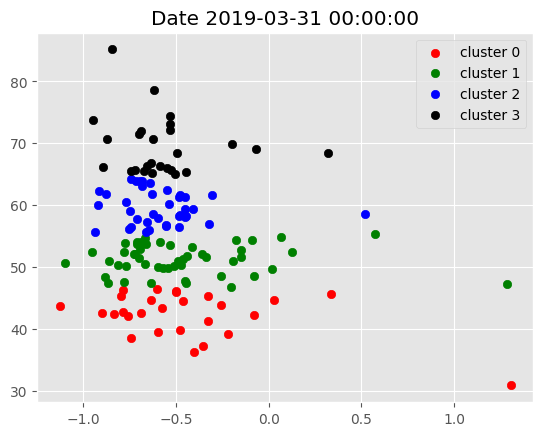

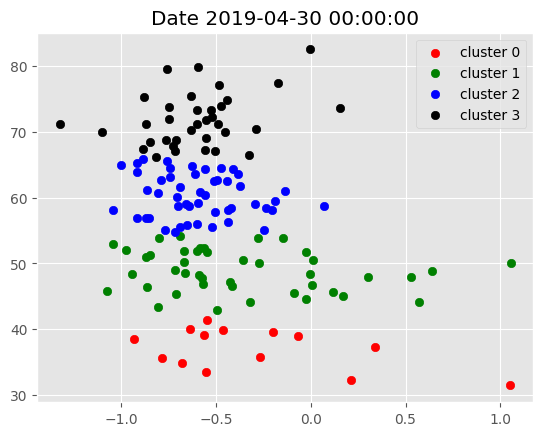

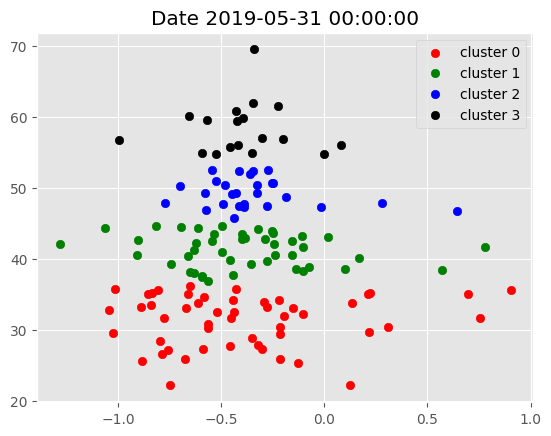

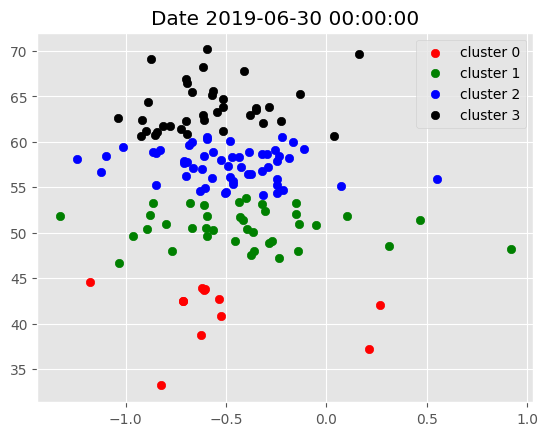

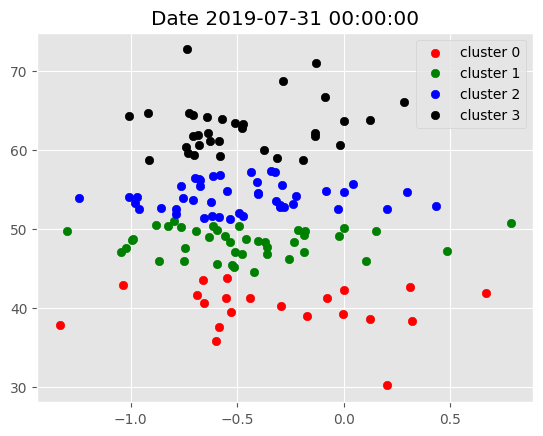

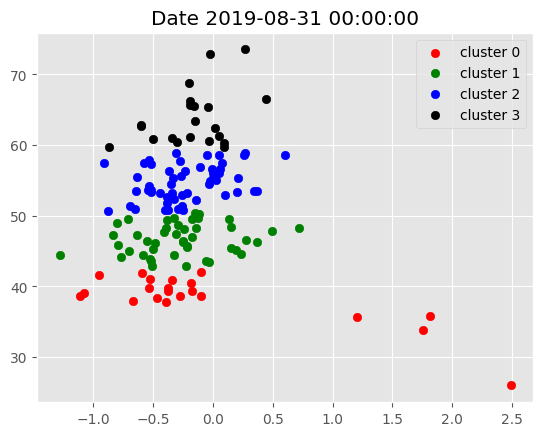

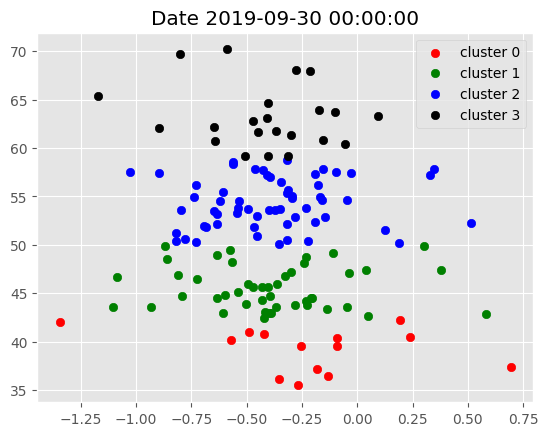

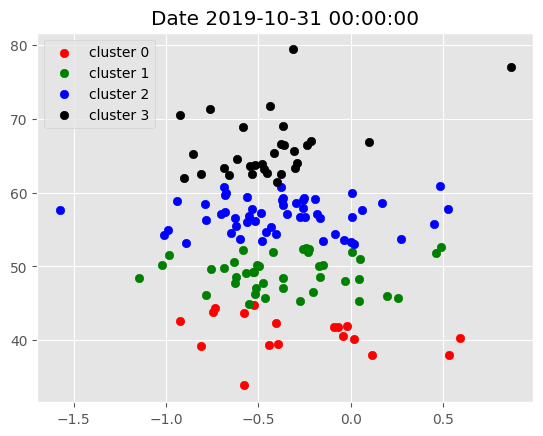

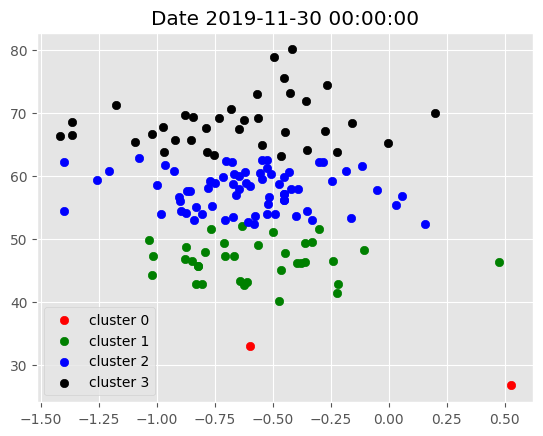

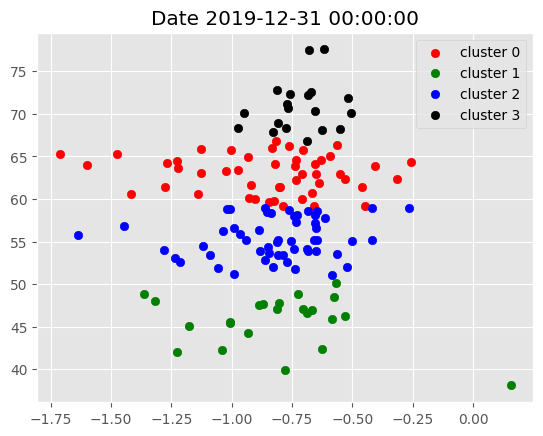

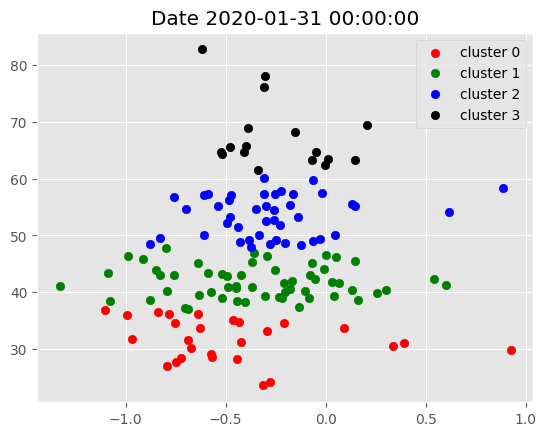

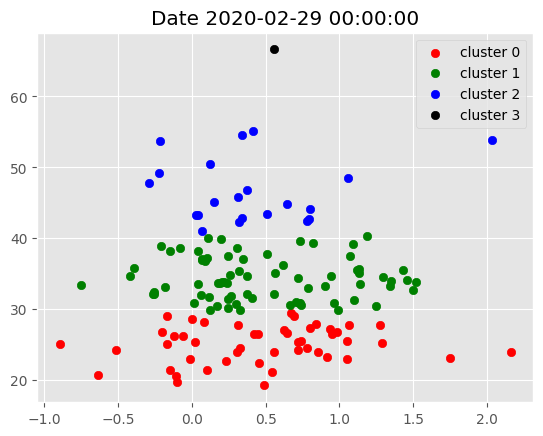

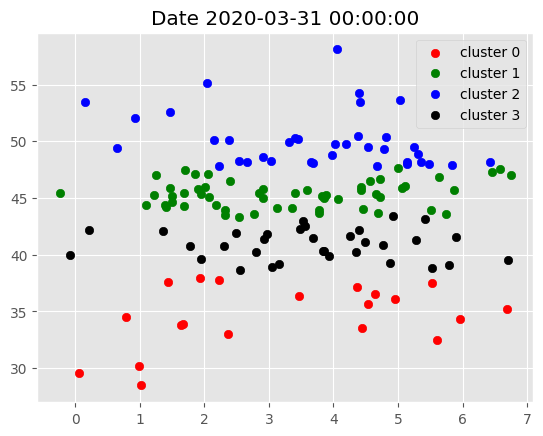

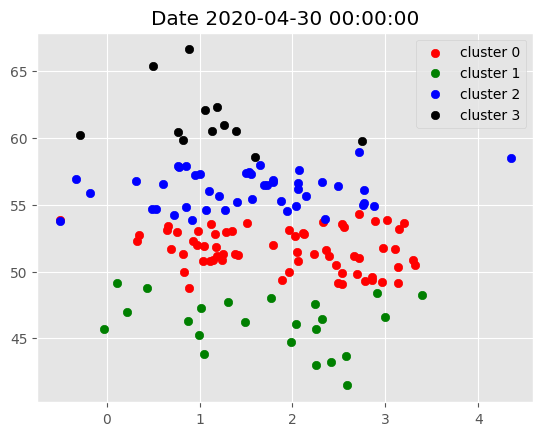

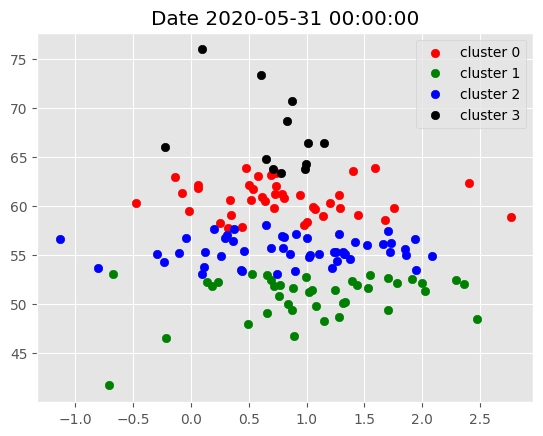

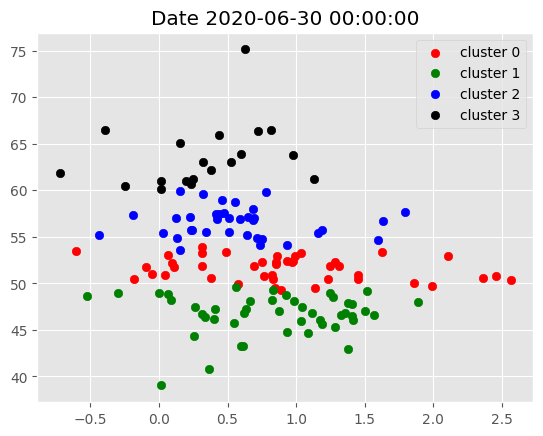

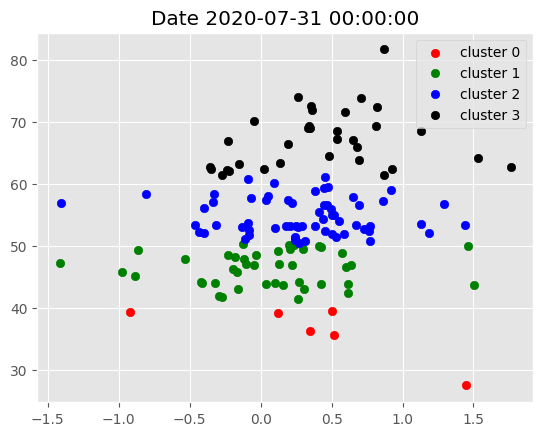

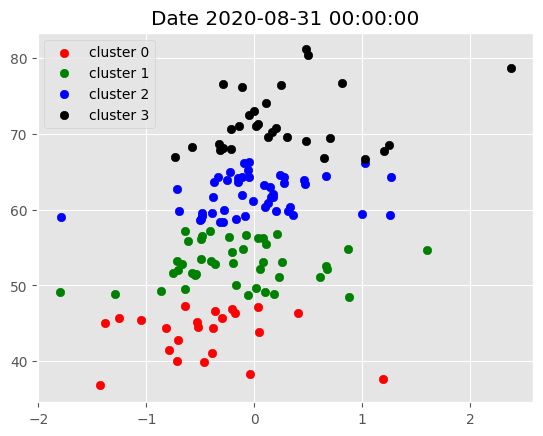

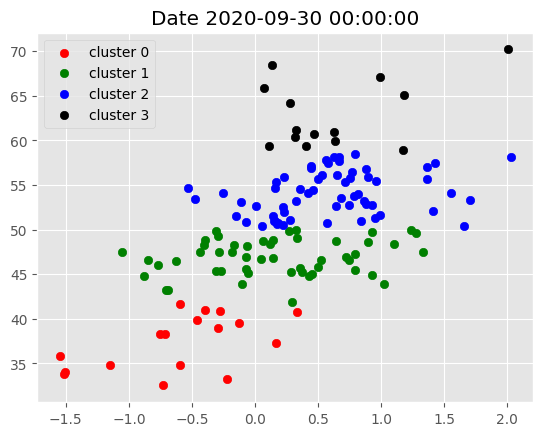

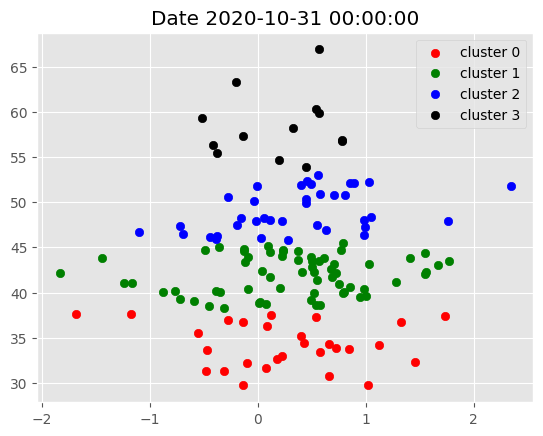

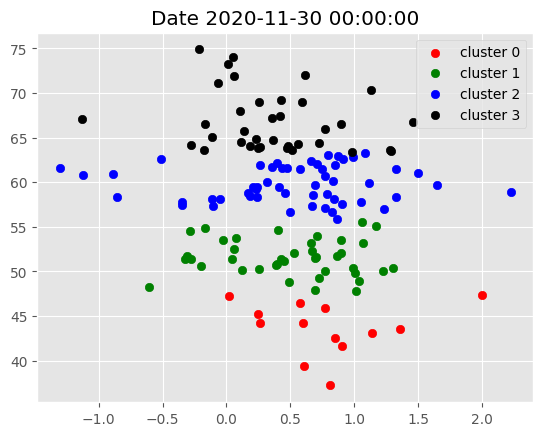

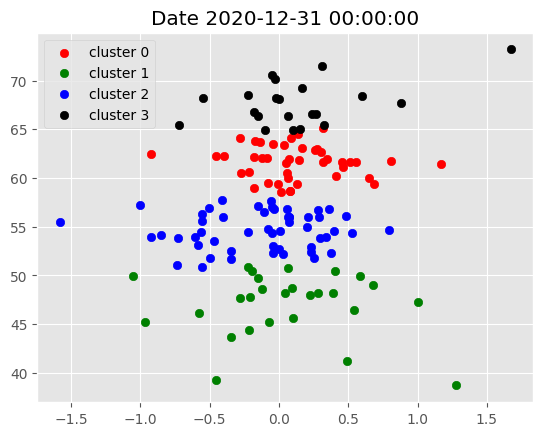

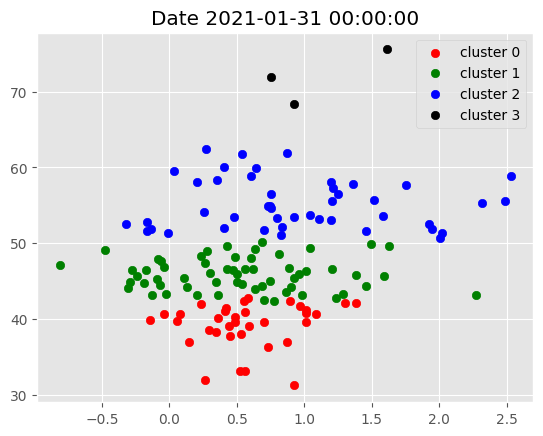

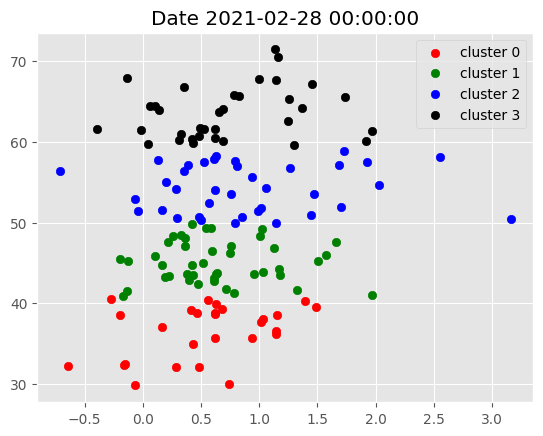

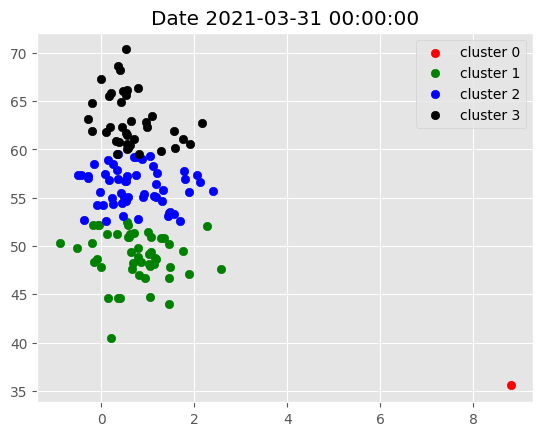

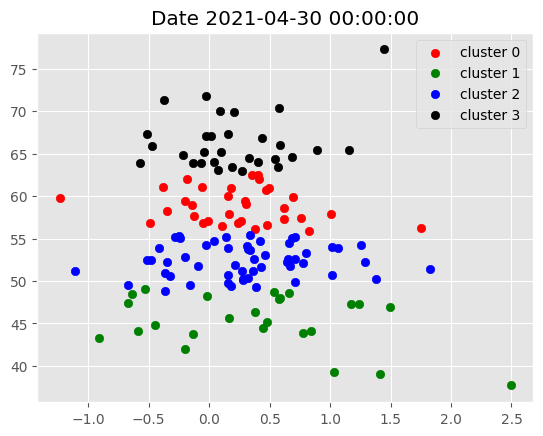

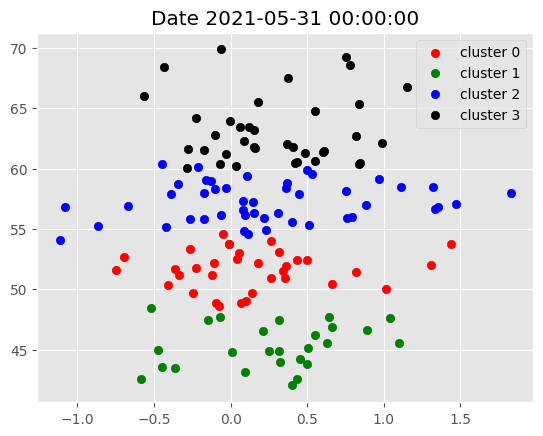

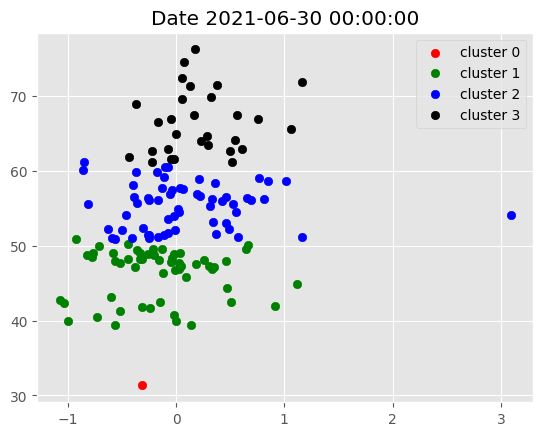

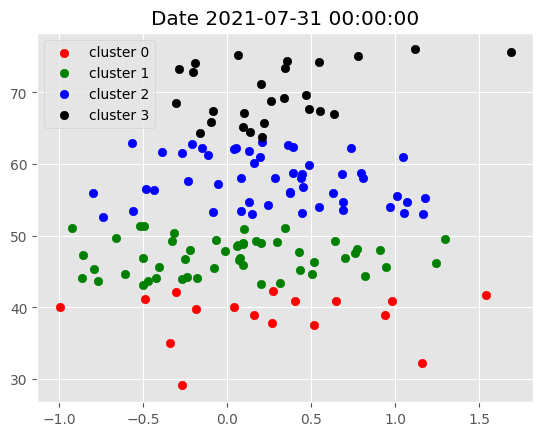

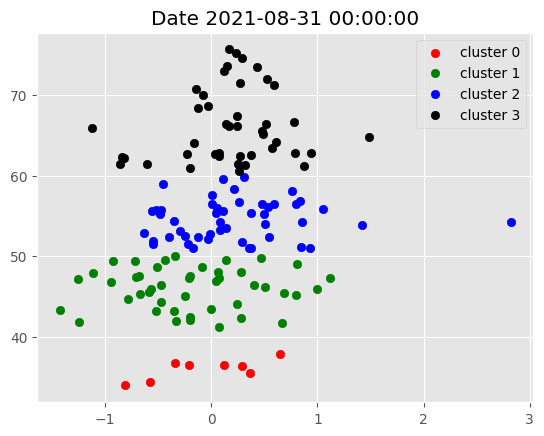

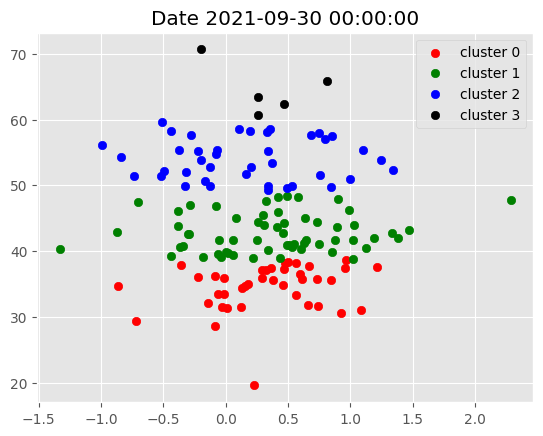

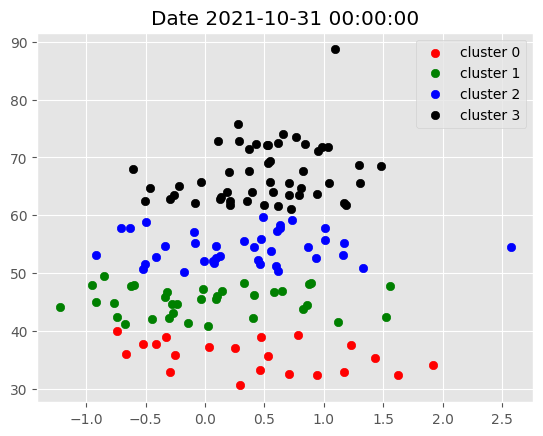

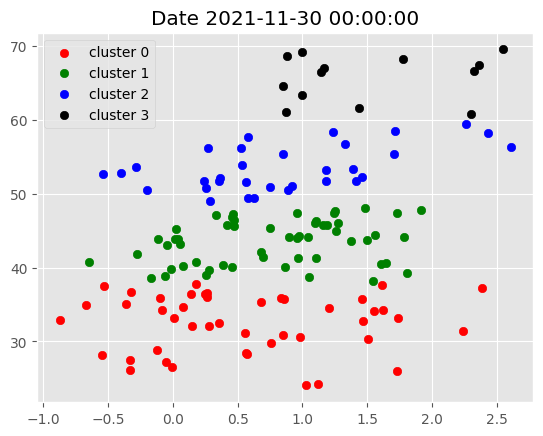

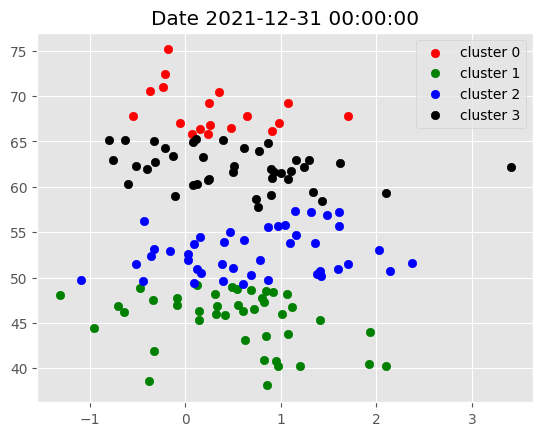

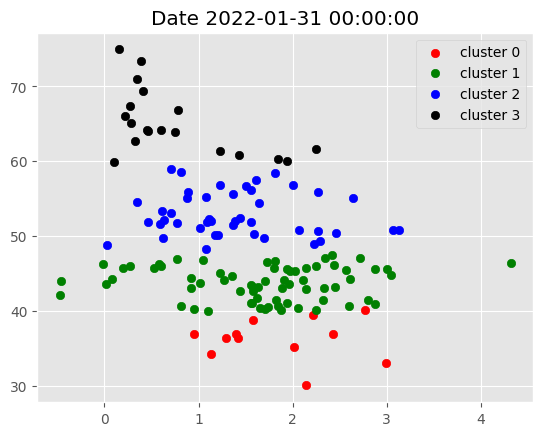

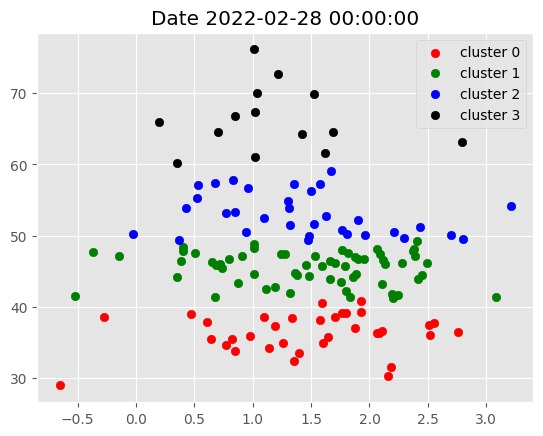

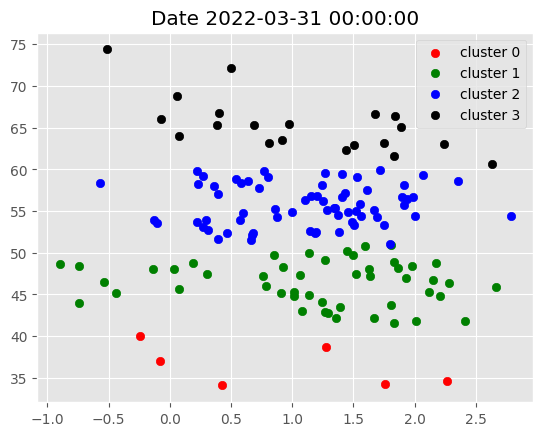

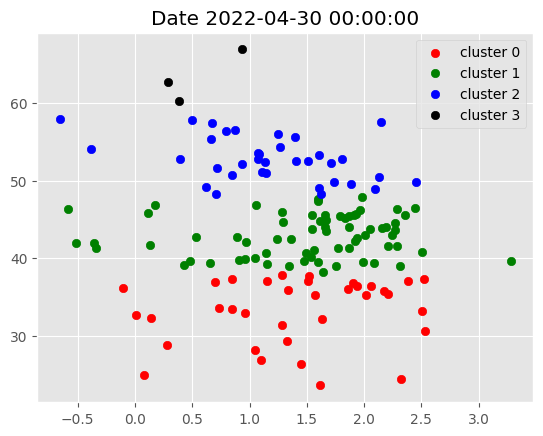

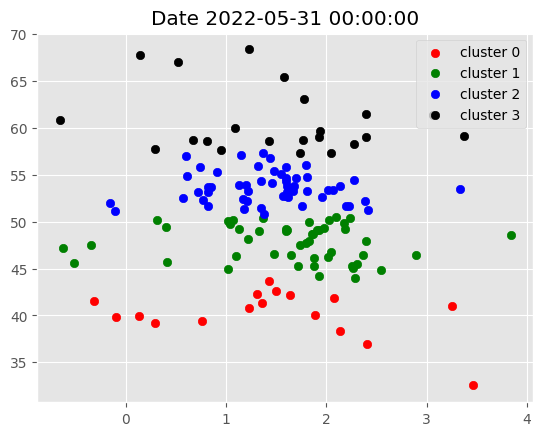

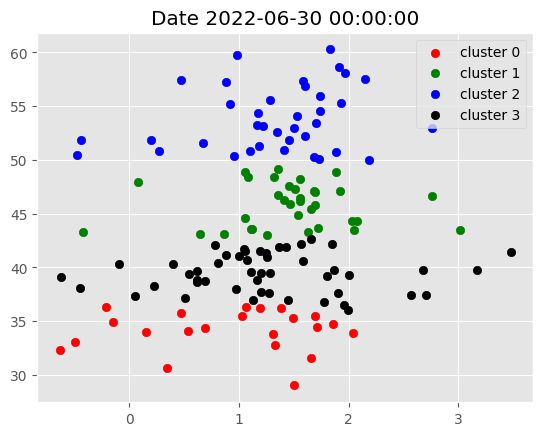

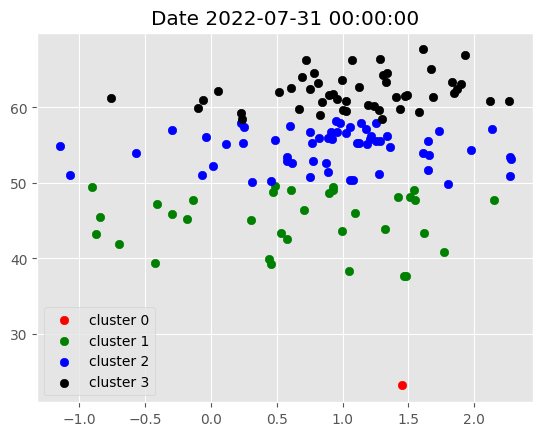

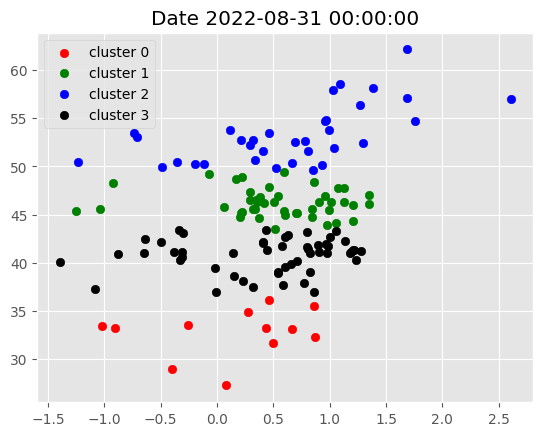

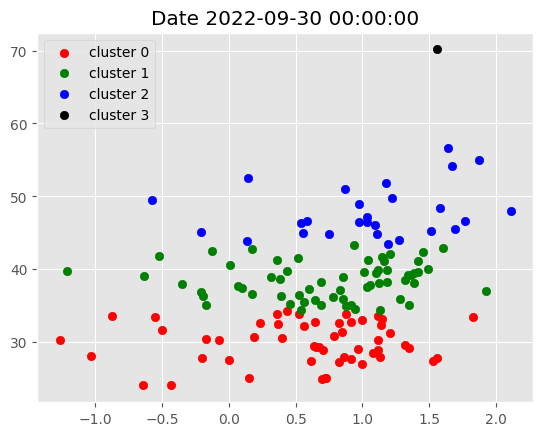

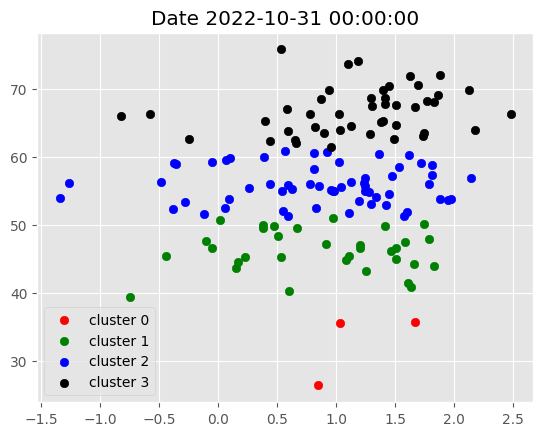

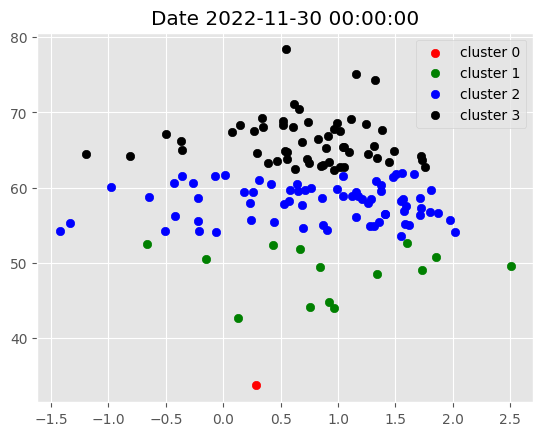

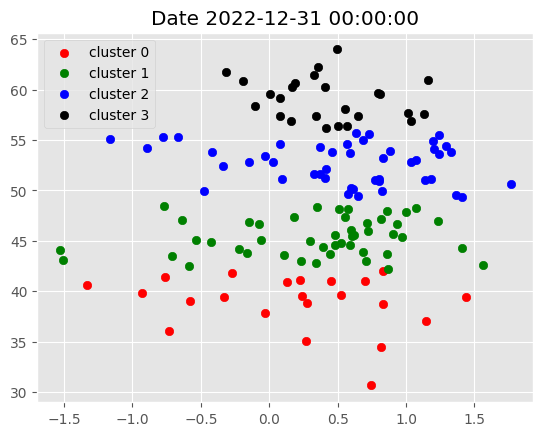

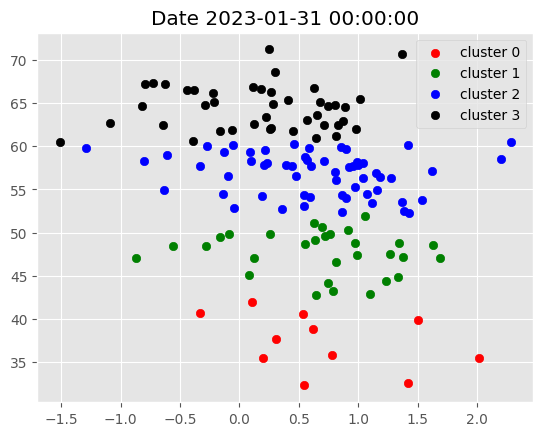

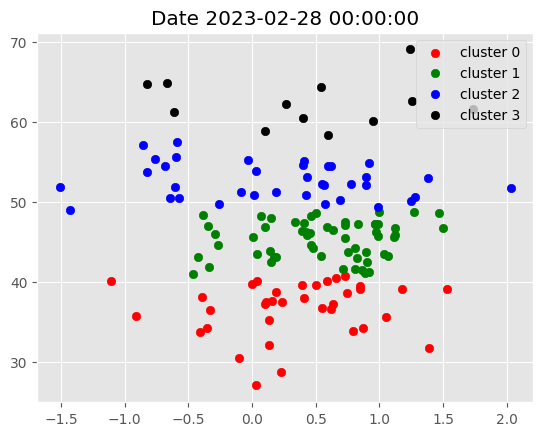

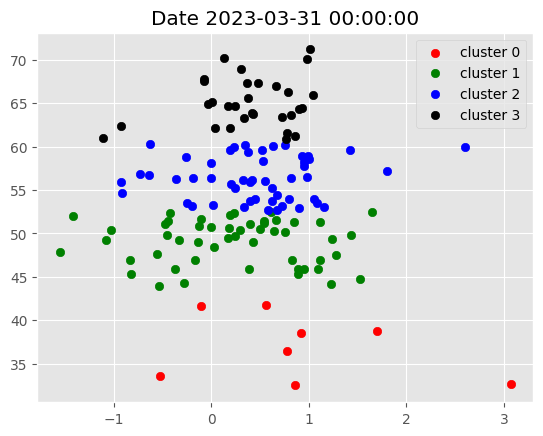

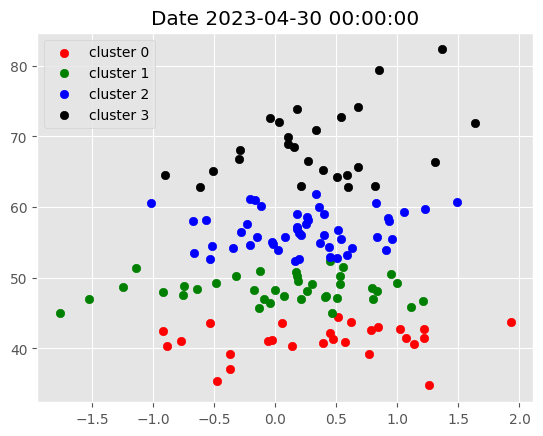

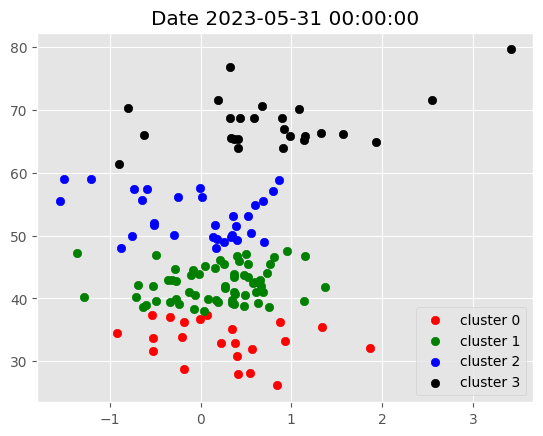

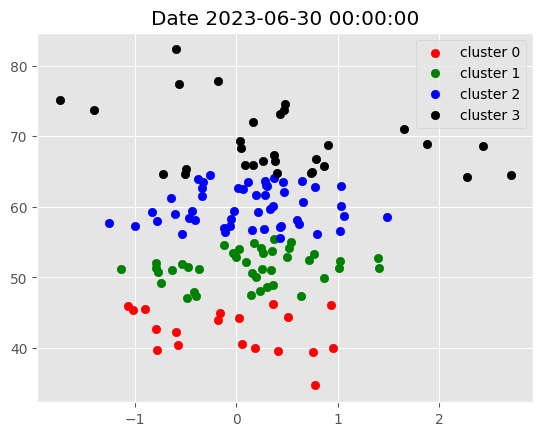

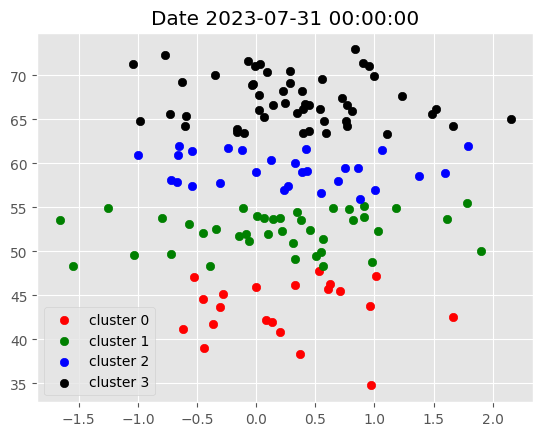

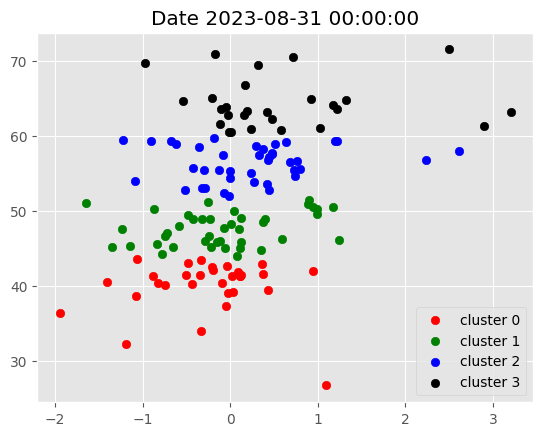

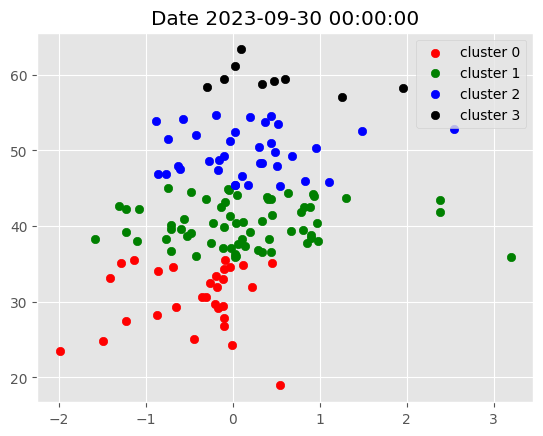

In [18]:
#Import the KMeans clustering algorithm from scikit-learn
from sklearn.cluster import KMeans

"""
# Drop any existing 'cluster' column from the data
# This ensures that any previous clustering labels are removed before applying the new clustering process.
# It is important to start with a clean dataset to avoid potential conflicts or inaccuracies in the clustering results.
"""
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Function to Apply KMeans Clustering to the Data for Each Date
def get_clusters(df):
    """
    # Apply KMeans clustering to the data, creating 4 distinct clusters
    # The number of clusters (n_clusters=4) is predetermined based on domain knowledge or prior experimentation.
    # random_state=0 ensures reproducibility of the clustering results by setting the random seed.
    # init=initial_centroids allows us to specify the initial centroids for KMeans, which can be important for achieving 
    # stable and meaningful clustering results, especially in an institutional setting where consistency is critical.
    """
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df
"""
# Drop rows with missing values (NaN) to ensure clean input data for clustering
# Missing data can lead to errors or biased clustering results, so it's crucial to handle NaNs appropriately.
# Group the data by 'date' and apply the get_clusters function to each group independently
# This ensures that the clustering is performed separately for each time period, capturing the evolving patterns in the data.
# In an institutional context, it's often necessary to track how asset classes or portfolios evolve over time,
# making it essential to apply clustering within each time slice (in this case, monthly or daily).
"""
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

# Atr = 5 RSI = 1
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

    #the coloring of the cluster cetroids is random
    #Strategy Follow Stocks Momentum: Stocks around 70 rsi are in upward momentum. Invest in stocks of high 60-75 upward rsi momentum


<h3>7.For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization</h3>
<ul>
    <li>First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.</li>
    <li>Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.</li>
</ul>

In [19]:
"""
# Filter the DataFrame to include only assets in cluster 3
# In this context, cluster 3 may represent a specific grouping of assets identified by a previous KMeans clustering process.
# We are focusing on this cluster as it has been identified as relevant for the Efficient Frontier optimization.
"""
filtered_df = data[data['cluster']==3].copy()

"""
# Reset the index to work with the 'ticker' level independently
# This step makes 'ticker' a regular column, which will allow for easier manipulation in subsequent steps.
"""
filtered_df = filtered_df.reset_index(level=1)

"""
# Adjust the date index by adding a 1-day offset
# This operation ensures that the optimization process for each month considers data from the previous month.
# By shifting the dates forward by one day, we align the data with the start of the new month, 
# which is important for forward-looking optimizations.
"""
filtered_df.index = filtered_df.index+pd.DateOffset(1)

"""
# Reset the index and then set it back to 'date' and 'ticker' levels
# This step reconfigures the DataFrame after the date adjustment, ensuring that 'date' and 'ticker' are the primary indices.
"""
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

"""
# Extract the unique dates from the index
# This list will be used to iterate over each month in the data for the optimization process.
"""
dates = filtered_df.index.get_level_values('date').unique().tolist()

"""
 Initialize a dictionary to store the selected assets for each date
# 'fixed_dates' will map each date to a list of tickers that correspond to the assets being considered for optimization.
"""
fixed_dates = {}

for d in dates:
    """
     # For each date, select the list of tickers that are part of the filtered DataFrame
    # These tickers represent the assets that will be included in the Efficient Frontier optimization for that specific month.
    # The xs function is used to extract the data corresponding to each date.
    """
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

"""
# The 'fixed_dates' dictionary now contains each date as a key, with the corresponding list of tickers as values.
# These tickers represent the assets that will be used in the Efficient Frontier Max Sharpe Ratio Optimization
# for each specific month. This setup is crucial for implementing dynamic portfolio strategies that adjust 
# asset selection on a monthly basis based on historical performance and clustering results.
fixed_dates
"""
fixed_dates


{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',


<h3>Define portfolio optimization function</h3>
<ul>
    <li>We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.</li>
    <li>To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.</li>
    <li>Apply signle stock weight bounds contraint for diversification (minimum half of equally weight and maximum 10% of portfolio).</li>
</ul>

In [20]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                       frequency = 252)
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix = cov,
                           weight_bounds=(lower_bound,.1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()
    

<h3>Download Fresh Daily Prices Data only for short listed stocks.</h3>

In [21]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), 
                     end=data.index.get_level_values('date').unique()[-1])

[*********************100%%**********************]  156 of 156 completed


In [22]:
new_df

Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134323   26.182175   39.878792  34.112476  103.117401   
2016-11-01  38.363209   25.709444   40.357796  33.947308  103.028709   
2016-11-02  38.276459   25.732502   40.600876  33.643028  105.219849   
2016-11-03  38.054207   25.456682   39.957424  33.364853  103.747246   
2016-11-04  38.402084   25.227213   40.064671  33.982082  103.995636   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.183578  148.897141  95.484741  311.950897   
2023-09-26  12.700000  171.084534  148.184677  94.270004  305.672363   
2023-09-27  12.610000  169.562332  147.433685  93.584259  309.382416   
2023-09-28  12.920000  169.821014  146.586426  96.121506  295.988770   
2023-09-29  12.810000  170.338379  143.515091  94.877373  302.227966   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   73.831520   72.279999  50.462044   26.606323  ...   
2016-11-01  106.870003   73.712791   70.099998  49.627831   26.441633  ...   
2016-11-02  105.889999   76.307846   68.680000  49.521496   26.158010  ...   
2016-11-03  107.169998   75.756607   67.610001  47.558640   25.865223  ...   
2016-11-04  106.199997   75.544609   69.440002  46.928886   25.819481  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844086  205.669998  61.170822  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068115  134.297562  ...   
2023-09-28  504.670013  239.076843  207.889999  60.333946  137.439728  ...   
2023-09-29  509.899994  236.394348  206.910004  59.664444  137.668442  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 936 columns]

In [23]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

Timestamp('2016-10-31 00:00:00')

<ul>
    <li>Calculate daily returns for each stock which could land up in our portfolio.</li>
    <li>Then loop over each month start, select the stocks for the month and calculate their weights for the next month.</li>
    <li>If the maximum sharpe ratio optimization fials for a given month, apply equally-weighted weights.</li>
    <li>Calculated each day portfolio return.</li>
</ul>

In [150]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        # Optimization is failing for the Max Sharpe Ratio
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                               lower_bound=round(1/(len(optimization_df.columns)*2),3))
            # Convert weights to DataFrame with correct structure
            weights_df = pd.DataFrame(list(weights.items()), columns=['Ticker', 'weight'])
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                      index=optimization_df.columns.tolist(),
                      columns=pd.Series(0)).T
            # print(weights)
    
        temp_df = returns_dataframe[start_date:end_date]
    
        # Stack temp_df and reset the index
        returns_df = temp_df.stack().to_frame('return').reset_index(level=0)
       
    
        
        
        # # Merge based on the 'Ticker' from returns_df and 'index' from weights_df
        # # Merge returns_df with weights_df on the 'Ticker' column
        merged_df = returns_df.merge(weights_df, on='Ticker', how='left')
    
        # # Set the index back to 'Ticker' and 'Date' if desired
        merged_df = merged_df.set_index(['Ticker', 'Date'])
    
        merged_df['weighted_return'] = merged_df['return']*merged_df['weight']
    
        merged_df = merged_df.groupby(level=1)['weighted_return'].sum().to_frame('Strategy Return')
        # print(merged_df.head())
    
        portfolio_df = pd.concat([portfolio_df, merged_df], axis=0)
    
        # print(portfolio_df.head())

    except Exception as e:
        print(e)
    
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
   

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights


Strategy Return
Date                       
2017-11-01         0.001481
2017-11-02         0.003026
2017-11-03         0.006365
2017-11-06         0.002789
2017-11-07         0.003080
...                     ...
2023-09-25         0.003459
2023-09-26        -0.012075
2023-09-27         0.004926
2023-09-28         0.008140
2023-09-29        -0.007476

[1487 rows x 1 columns]

In [25]:
optimization_df = new_df['2016-11-01':'2017-10-30']['Adj Close'][fixed_dates['2017-11-01']]
optimization_df 


Ticker           AAPL         ACN        ADBE       AMAT       AMZN  \
Date                                                                  
2016-11-01  25.709444  103.028709  106.870003  26.441633  39.270500   
2016-11-02  25.732502  105.219849  105.889999  26.158010  38.278000   
2016-11-03  25.456682  103.747246  107.169998  25.865223  38.351501   
2016-11-04  25.227213  103.995636  106.199997  25.819481  37.752499   
2016-11-07  25.591120  106.426323  108.660004  26.835056  39.246498   
...               ...         ...         ...        ...        ...   
2017-10-24  36.866070  125.712471  171.580002  52.133316  48.794998   
2017-10-25  36.704159  127.748718  171.830002  51.134655  48.645500   
2017-10-26  36.938824  128.481766  173.750000  51.717213  48.621498   
2017-10-27  38.262344  129.667282  177.330002  52.419956  55.047501   
2017-10-30  39.123566  129.676361  176.029999  51.689476  55.542500   

Ticker           AVGO        AXP        BAC         CAT        COP  ...  \
Date                                                                ...   
2016-11-01  13.223001  59.281784  13.979828   68.286949  34.227024  ...   
2016-11-02  13.517543  58.565926  13.870412   67.348679  33.983337  ...   
2016-11-03  13.551229  58.458553  13.870412   67.481529  34.274204  ...   
2016-11-04  13.486997  58.619621  13.929329   68.345055  33.613880  ...   
2016-11-07  13.862217  59.952892  14.316490   69.540779  34.525768  ...   
...               ...        ...        ...         ...        ...  ...   
2017-10-24  19.765450  85.340111  23.652018  118.243103  40.989006  ...   
2017-10-25  19.617022  85.040077  23.609293  117.045586  40.161026  ...   
2017-10-26  19.452623  87.004021  23.703285  117.131134  41.366817  ...   
2017-10-27  20.182018  87.094933  23.754553  117.875298  41.165863  ...   
2017-10-30  20.846769  86.440292  23.583662  116.746239  41.310551  ...   

Ticker           ORCL       PYPL         SHW         STZ        TXN  \
Date                                                                  
2016-11-01  33.985313  41.540001   74.673363  146.202194  55.833179   
2016-11-02  33.605350  41.349998   75.247482  146.425812  55.350742   
2016-11-03  33.852768  41.189999   74.949554  143.178833  54.994373   
2016-11-04  33.826252  40.900002   75.266098  143.107101  54.751392   
2016-11-07  34.542011  41.279999   76.951134  148.792282  55.893398   
...               ...        ...         ...         ...        ...   
2017-10-24  44.873257  70.209999  122.020203  192.272018  79.575363   
2017-10-25  44.621864  71.019997  123.159134  192.118347  79.063774   
2017-10-26  45.025894  71.339996  124.401550  191.449173  79.336067   
2017-10-27  45.681305  71.059998  124.649399  191.593887  80.449997   
2017-10-30  45.501736  71.150002  123.695641  192.588501  79.769073   

Ticker             UNH           V        VLO        WMT        XOM  
Date                                                                 
2016-11-01  124.250740   77.204689  42.773808  19.960337  58.367043  
2016-11-02  123.849724   76.220924  42.011658  20.003546  58.227493  
2016-11-03  122.824905   76.287125  41.601826  20.055391  58.374008  
2016-11-04  122.717987   76.012817  41.609020  19.920017  58.311203  
2016-11-07  126.478531   78.046532  42.076385  20.098591  59.622993  
...                ...         ...        ...        ...        ...  
2017-10-24  188.406342  103.305595  58.175037  26.044577  60.434540  
2017-10-25  187.872330  104.334740  58.167561  26.192593  60.217319  
2017-10-26  189.311523  104.630150  57.126717  26.234030  60.434540  
2017-10-27  192.434250  104.544395  58.219990  26.100824  60.608307  
2017-10-30  189.528732  104.858841  58.706707  25.739668  60.485203  

[251 rows x 44 columns]

<Axes: xlabel='Date'>

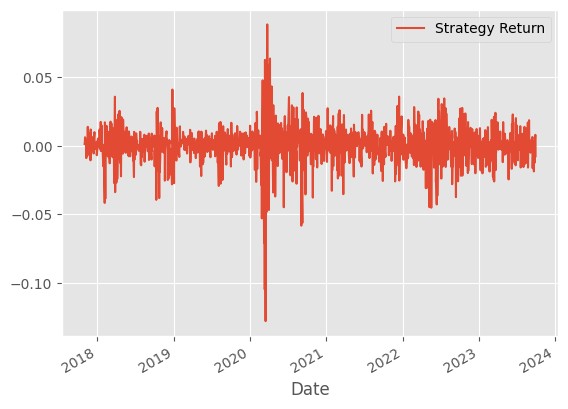

In [147]:
portfolio_df.plot()

<h3>8. Visualize Portfolio returns and compare to SP500 returns.</h3>

In [158]:
# spy = yf.download(tickers='SPY',
#                   start='2015-01-01',
#                   end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

Strategy Return  SPY Buy&Hold
Date                                     
2017-11-01         0.001481      0.001321
2017-11-02         0.003026      0.000388
2017-11-03         0.006365      0.003333
2017-11-06         0.002789      0.001546
2017-11-07         0.003080     -0.000696
...                     ...           ...
2023-09-25         0.003459      0.004196
2023-09-26        -0.012075     -0.014800
2023-09-27         0.004926      0.000399
2023-09-28         0.008140      0.005781
2023-09-29        -0.007476     -0.002430

[1487 rows x 2 columns]

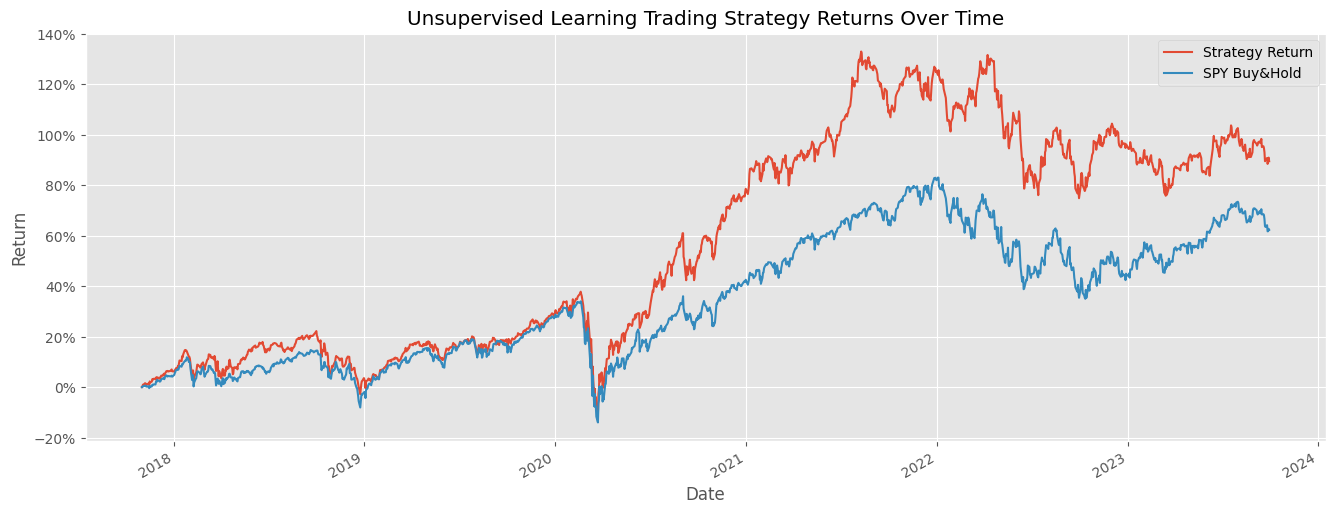

In [164]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

<ul>
    <li>Selected 150 most liquid stocks</li>
    <li>Calculated 18 different features</li>
    <li>KMeans clustering</li>
    <li>Initialized Centroids with Custom Array</li>
    <li>Maximum Sharpe Portfolio Weights</li>
</ul>